# Gene Expression Visualization: K562 data (Replogle 2022)
- download `K562_essential_raw_singlecell_01.h5ad` from [https://plus.figshare.com/articles/dataset/_Mapping_information-rich_genotype-phenotype_landscapes_with_genome-scale_Perturb-seq_Replogle_et_al_2022_processed_Perturb-seq_datasets/20029387](https://plus.figshare.com/articles/dataset/_Mapping_information-rich_genotype-phenotype_landscapes_with_genome-scale_Perturb-seq_Replogle_et_al_2022_processed_Perturb-seq_datasets/20029387) and save it to `/WhyDOE_RWD_Analysis/`
- run codes in `01_preprocessing.ipynb` to have the processed data `K562_processed.h5ad`

In [1]:
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scanpy as sc
import seaborn as sns

from tools.preferences import level_cmap, seurat, outputdir, kwarg_savefig
from tools.bioinfo import GeneList
import tools.bioinfo.scanpy_extensions as sce
from tools.grn import HillClimbSearch
from tools.grn.grn_features import *

In [2]:
df = sc.read_h5ad("./K562_processed.h5ad")

In [3]:
hallmark = gp.get_library(name='MSigDB_Hallmark_2020', organism='Human')
hallmark.keys()

INFO:root:Downloading and generating Enrichr library gene sets...


dict_keys(['TNF-alpha Signaling via NF-kB', 'Hypoxia', 'Cholesterol Homeostasis', 'Mitotic Spindle', 'Wnt-beta Catenin Signaling', 'TGF-beta Signaling', 'IL-6/JAK/STAT3 Signaling', 'DNA Repair', 'G2-M Checkpoint', 'Apoptosis', 'Notch Signaling', 'Adipogenesis', 'Estrogen Response Early', 'Estrogen Response Late', 'Androgen Response', 'Myogenesis', 'Protein Secretion', 'Interferon Alpha Response', 'Interferon Gamma Response', 'Apical Junction', 'Apical Surface', 'Hedgehog Signaling', 'Complement', 'Unfolded Protein Response', 'PI3K/AKT/mTOR  Signaling', 'mTORC1 Signaling', 'E2F Targets', 'Myc Targets V1', 'Myc Targets V2', 'Epithelial Mesenchymal Transition', 'Inflammatory Response', 'Xenobiotic Metabolism', 'Fatty Acid Metabolism', 'Oxidative Phosphorylation', 'Glycolysis', 'Reactive Oxygen Species Pathway', 'p53 Pathway', 'UV Response Up', 'UV Response Dn', 'Angiogenesis', 'heme Metabolism', 'Coagulation', 'IL-2/STAT5 Signaling', 'Bile Acid Metabolism', 'Pperoxisome', 'Allograft Rejec

In [4]:
import logging
logging.getLogger("fontTools").setLevel(logging.WARNING)
logging.getLogger("pgmpy").setLevel(logging.WARNING)

---
## Cell Cycle

In [5]:
s_genes = GeneList(
    adata=df, key="s_phase_exclusive", category="E2F Targets", 
    database=hallmark, preset=True, caption="S phase"
)
g2m_genes = GeneList(
    adata=df, key="g2m_phase_exclusive", category="G2-M Checkpoint", 
    database=hallmark, preset=True, caption="G2/M phase"
)

[Cache Hit] Loading 's_phase_exclusive'...
[Cache Hit] Loading 'g2m_phase_exclusive'...


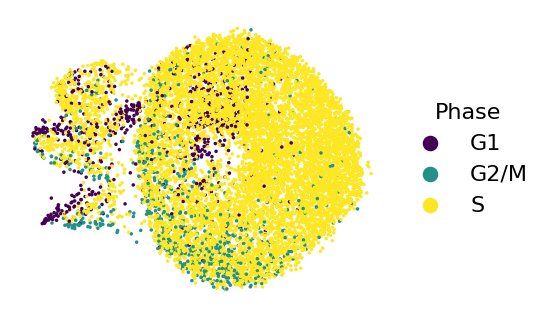

In [6]:
fig, ax = plt.subplots(figsize=(3, 3))

sce.pl.umap(
    df, ax=ax, size=10, color="phase", palette="viridis", title="Phase"
)

fig.savefig(f"{outputdir}/phase.pdf", **kwarg_savefig)

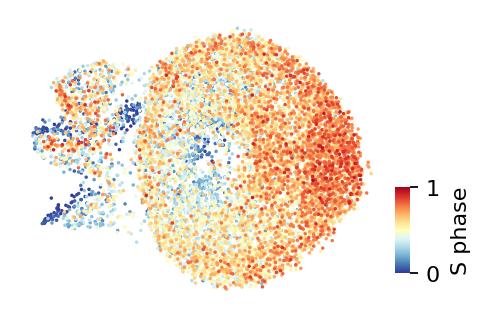

In [7]:
fig, ax = plt.subplots(figsize=(3, 3))

sce.pl.umap(
    df, ax=ax, size=10, color="S_score_prob", 
    palette="viridis", title=s_genes.caption, 
    vmax=1, vmin=0, cmap="RdYlBu_r"
)

fig.savefig(f"{outputdir}/S_score.pdf", **kwarg_savefig)

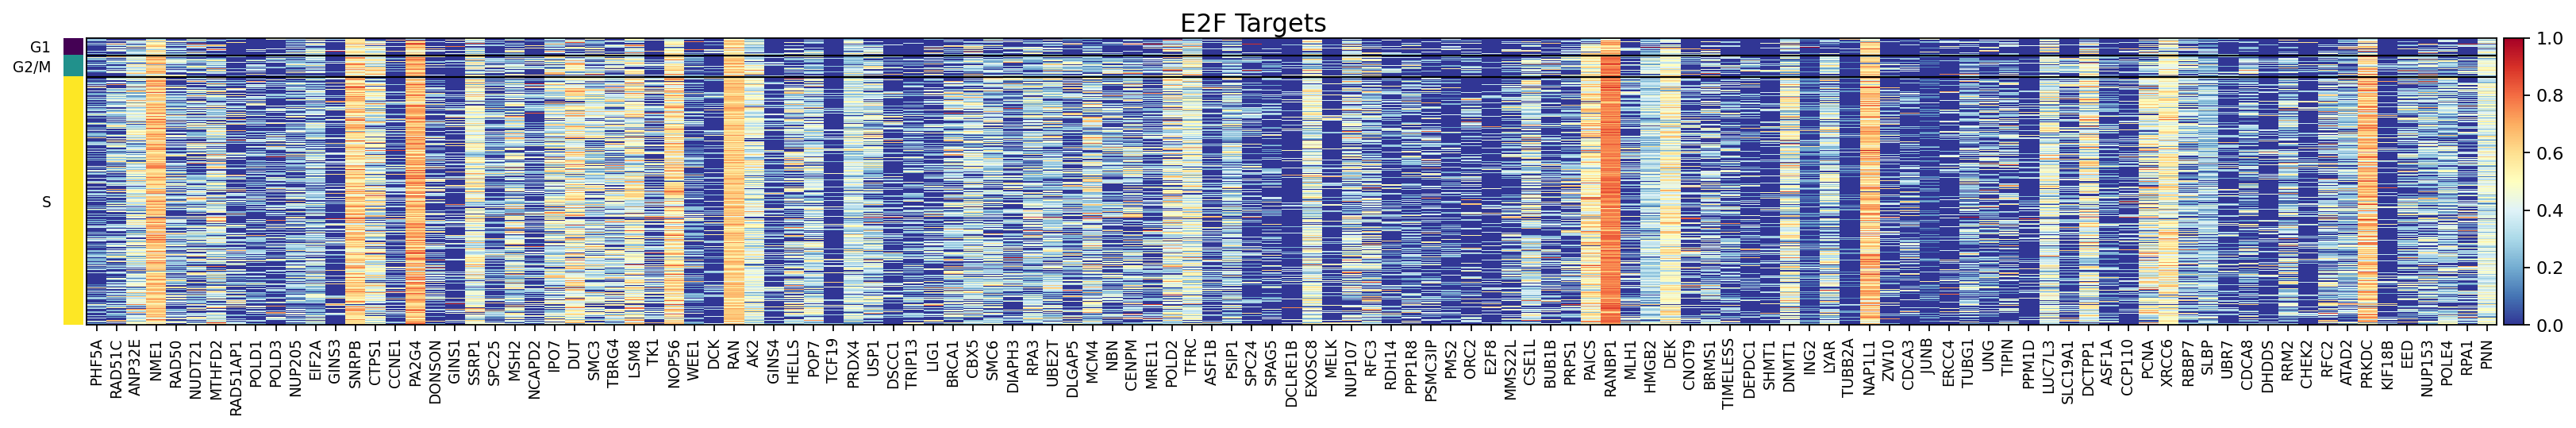

In [21]:
axes_dict = sc.pl.heatmap(
    df,
    var_names=s_genes.genes,
    groupby="phase",
    gene_symbols="gene_name",
    standard_scale="var",
    show_gene_labels=True,
    swap_axes=False,
    figsize=(25, 3),
    show=False,
    cmap="RdYlBu_r",
    rasterized=True
)

heatmap_ax, group_ax = axes_dict.values()
group_ax.set(ylabel="");
group_ax.set_xticklabels(group_ax.get_xticklabels(), rotation=0)


fig = heatmap_ax.figure
fig.suptitle(
    s_genes.category, 
    fontsize="x-large",
    y=.93
)

fig.savefig(f"{outputdir}/S_signature.pdf", **kwarg_savefig)

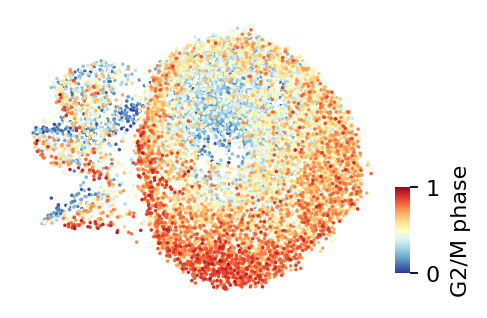

In [9]:
fig, ax = plt.subplots(figsize=(3, 3))

sce.pl.umap(
    df, ax=ax, size=10, color="G2M_score_prob", 
    palette="viridis", title=g2m_genes.caption, 
    vmax=1, vmin=0, cmap="RdYlBu_r"
)

fig.savefig(f"{outputdir}/G2M_score.pdf", **kwarg_savefig)

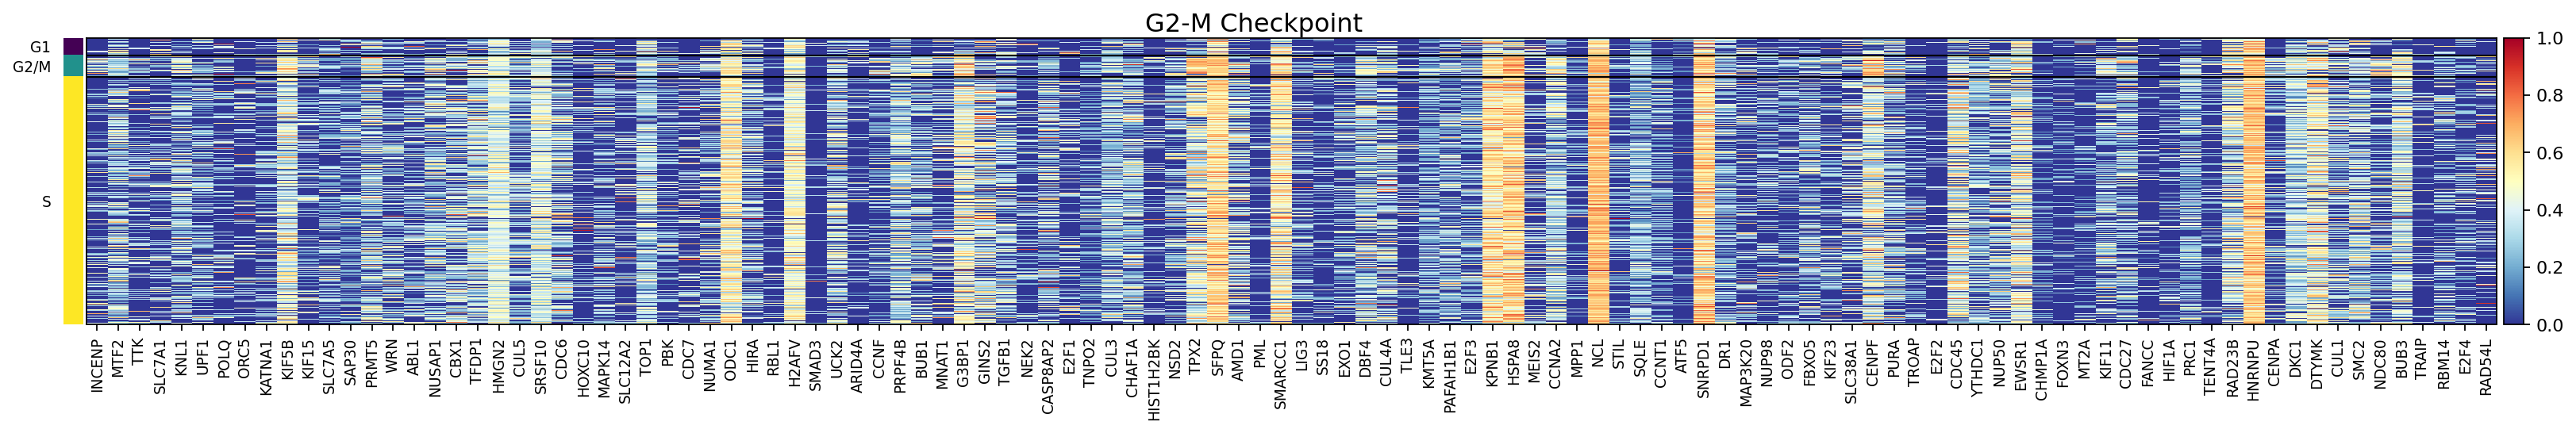

In [22]:
axes_dict = sc.pl.heatmap(
    df,
    var_names=g2m_genes.genes,
    groupby="phase",
    gene_symbols="gene_name",
    standard_scale="var",
    show_gene_labels=True,
    swap_axes=False,
    figsize=(25, 3),
    show=False,
    cmap="RdYlBu_r",
    rasterized=True
)

heatmap_ax, group_ax = axes_dict.values()
group_ax.set(ylabel="");
group_ax.set_xticklabels(group_ax.get_xticklabels(), rotation=0)


fig = heatmap_ax.figure
fig.suptitle(
    g2m_genes.category, 
    fontsize="x-large",
    y=.93
)

fig.savefig(f"{outputdir}/G2M_signature.pdf", **kwarg_savefig)

---
## Myc response (V1)

In [11]:
gl = GeneList(
    df, key="myc_v1", category="Myc Targets V1",
    database=hallmark, preset=True,
    caption="Myc Response"
)

[Cache Hit] Loading 'myc_v1'...


/home/yokano/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/yokano/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


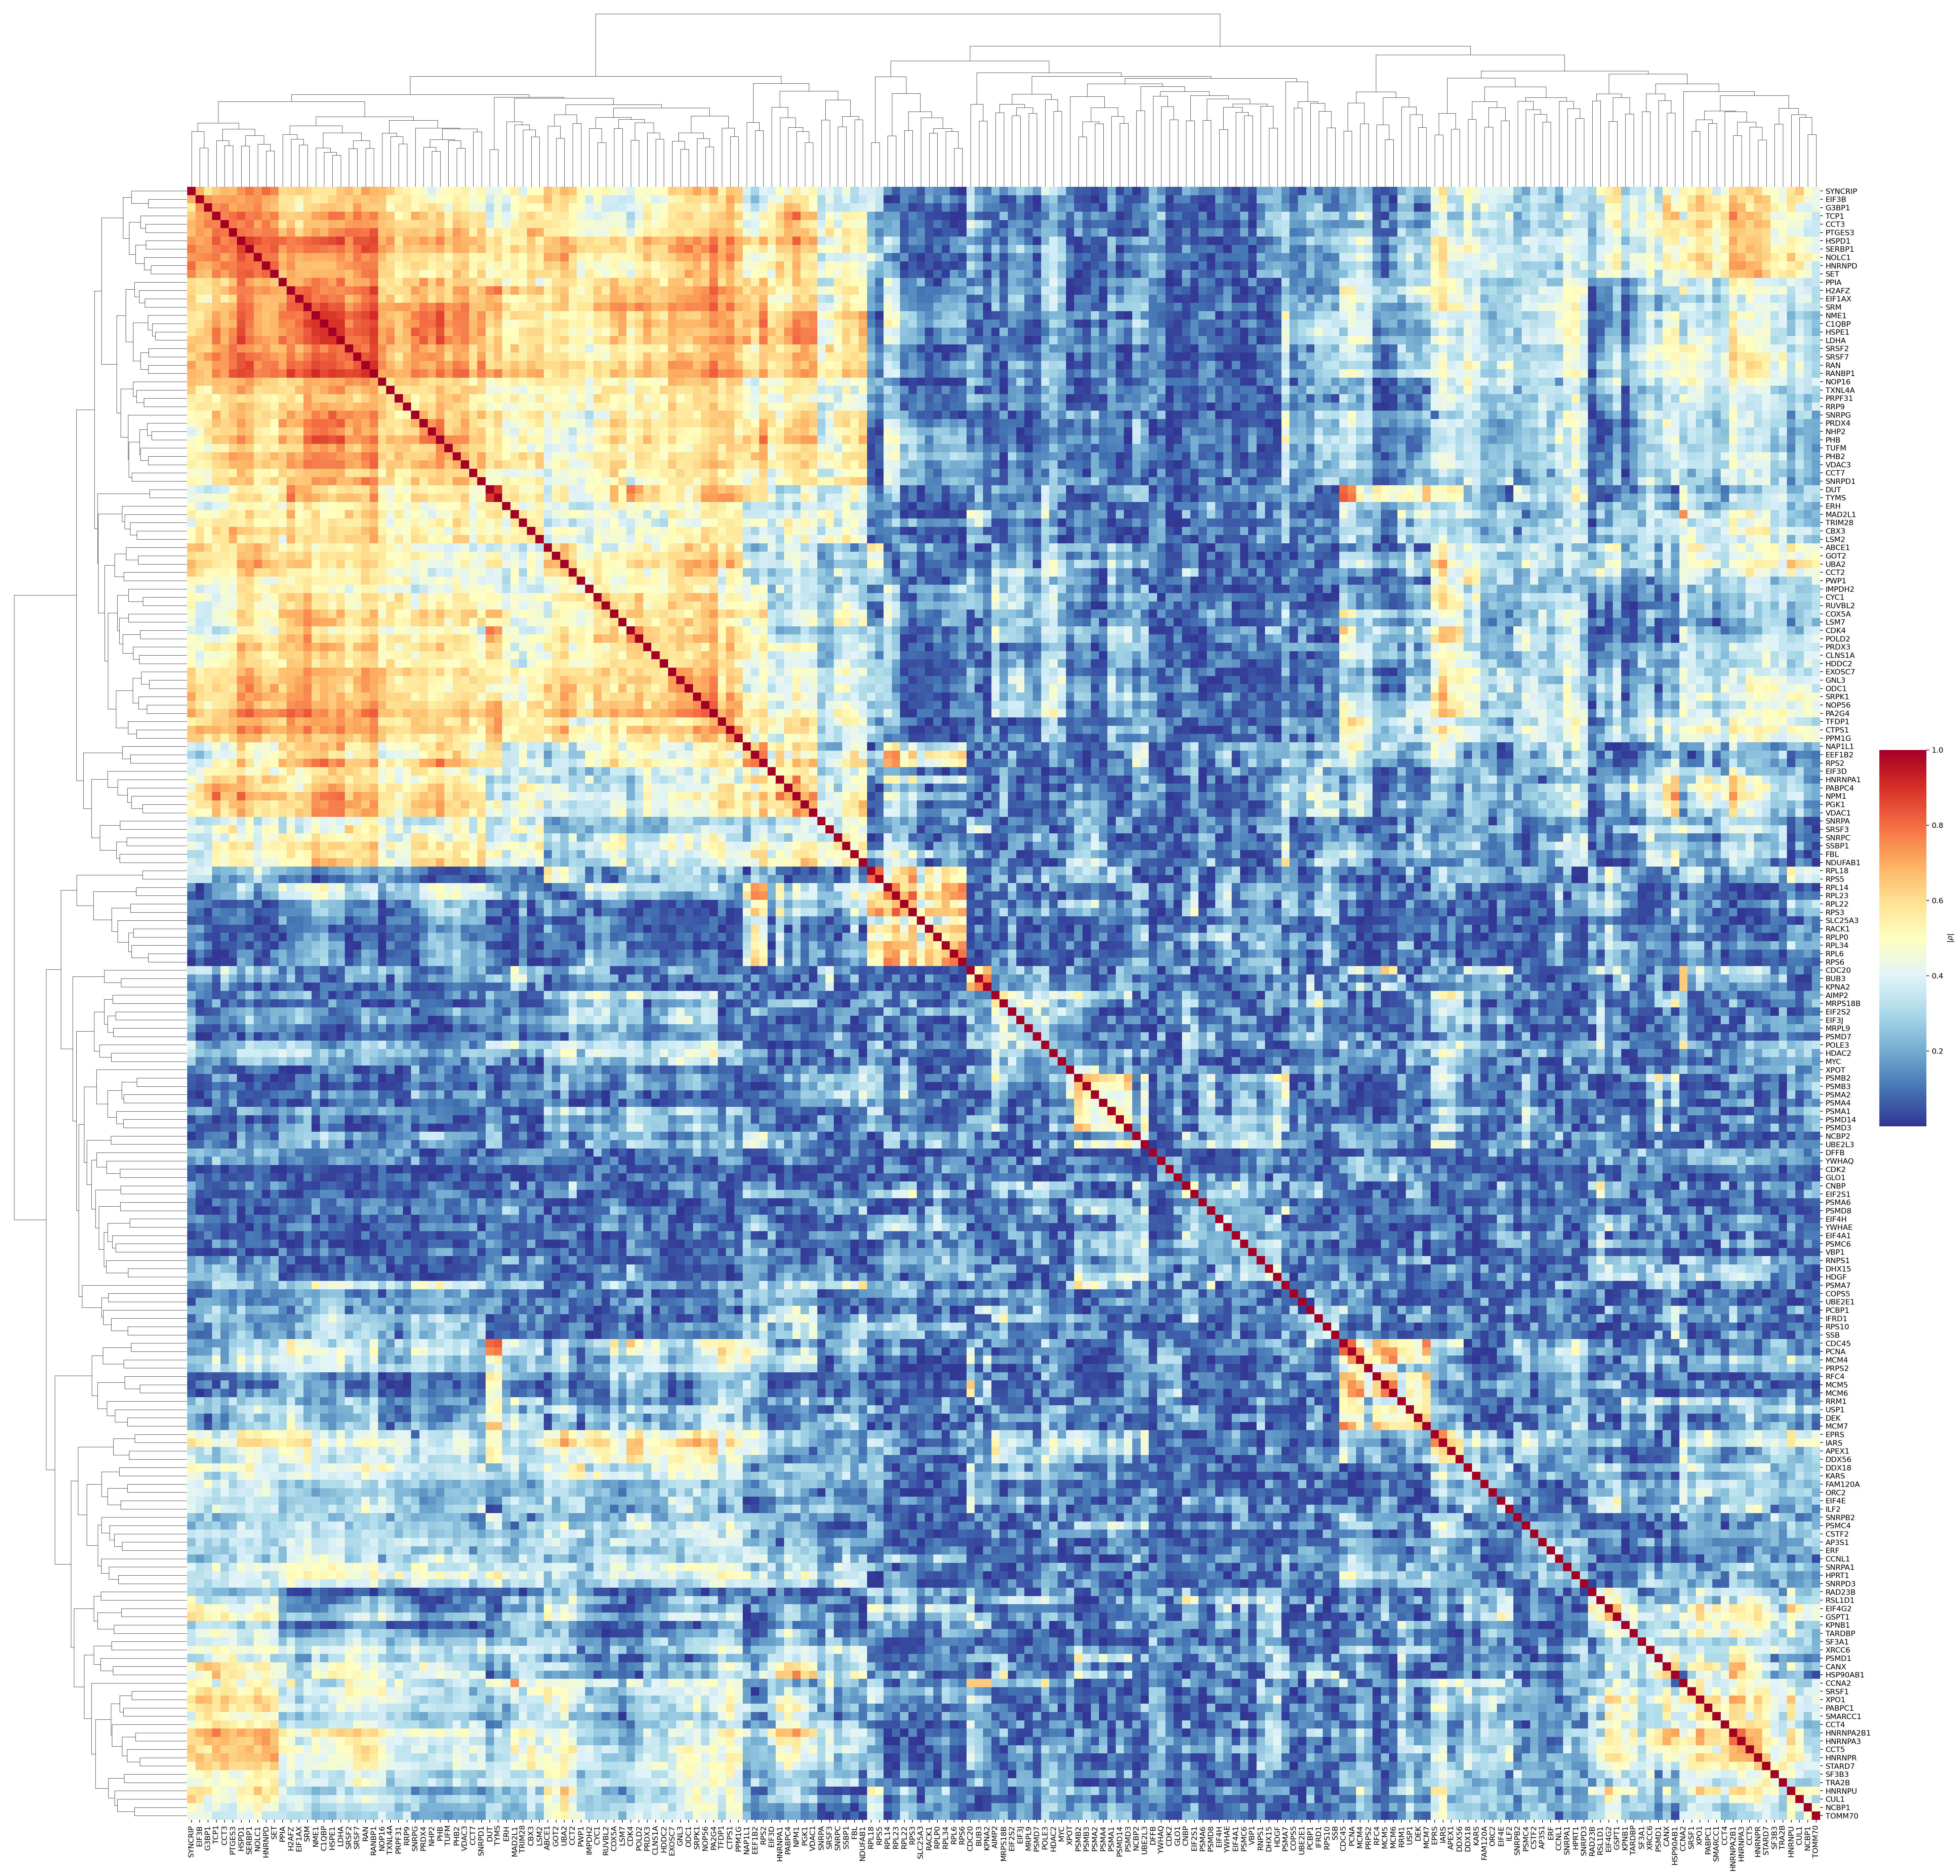

In [13]:
data = gl.data.to_df().assign(
    MetaCell=gl.data.obs["SEACells"]
).groupby("MetaCell", observed=False).mean()
data.columns.name = ""

clustergrid = sns.clustermap(
    data.corr().abs(),
    figsize=(35, 35),
    cbar_pos=(1, .4, .025, .2), 
    dendrogram_ratio=0.1, cmap="RdYlBu_r",
    xticklabels=gl.genes, yticklabels=gl.genes,
    cbar_kws={"label": r"$|\rho|$"},
    rasterized=True
)

plt.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_corr_all.pdf", **kwarg_savefig)

In [14]:
genes, ids = gl.select_correlated_genes(n_top=20)

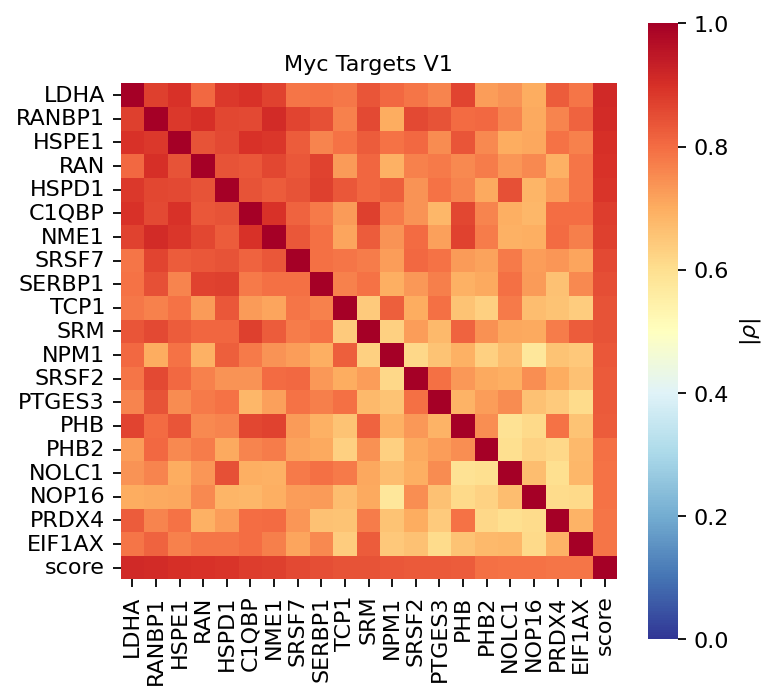

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(
    gl.get_matrix(with_score=True).corr().abs(),
    vmax=1, vmin=0, cmap="RdYlBu_r", square=True, 
    cbar_kws={"label": r"$|\rho|$"}, rasterized=True
)

ax.set(xlabel="", ylabel="");
ax.set_title(gl.category, fontsize="medium")

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_corr.pdf", **kwarg_savefig)

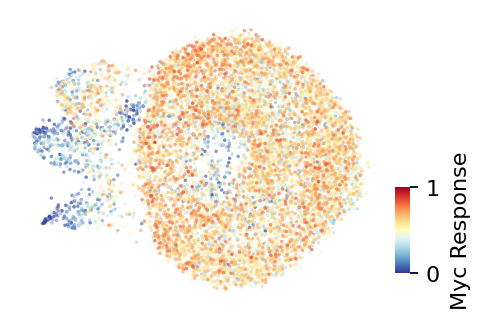

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))

sce.pl.umap(
    gl.data, ax=ax, size=10,
    color=gl.score_prob_name, vmax=1, vmin=0, cmap="RdYlBu_r",
    alpha=gl.data.obs[gl.score_prob_name], title=gl.caption
)

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_score.pdf", **kwarg_savefig)

In [17]:
np.random.seed(0)
random.seed(0)

grn = HillClimbSearch(gene_list=gl, output_value="S_score_prob")

  0%|          | 0/1000000 [00:00<?, ?it/s]

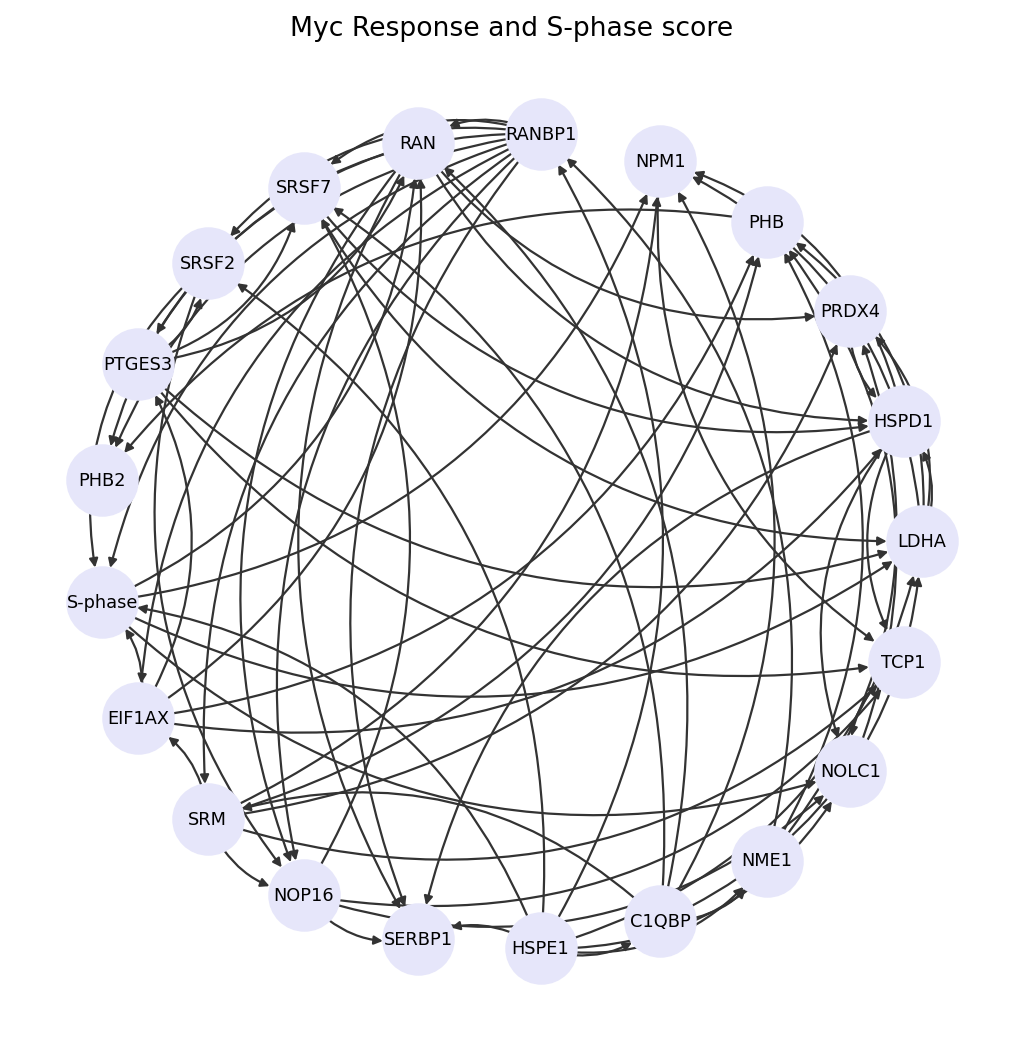

<Figure size 512x384 with 0 Axes>

In [18]:
plt.subplots(figsize=(8, 8))

grn.draw_graph(
    with_labels=True, 
    output_label="S-phase",
    node_color="lavender", edge_color=".2", 
    node_size=1000, font_size=8, width=1,
    arrows=True, arrowsize=8,
    connectionstyle="arc3,rad=0.3"
)

plt.title(f"{gl.caption} and S-phase score")
plt.show()

plt.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_grn_all.pdf", **kwarg_savefig)

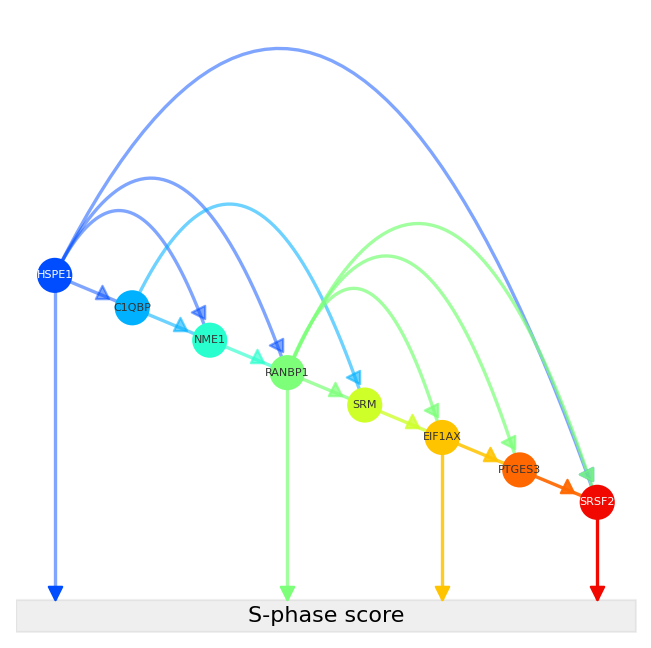

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))

grn.draw_grn(
    ax=ax, 
    output_label="S-phase score",
    markersize=250, fontsize=5
)

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_grn.pdf", **kwarg_savefig)

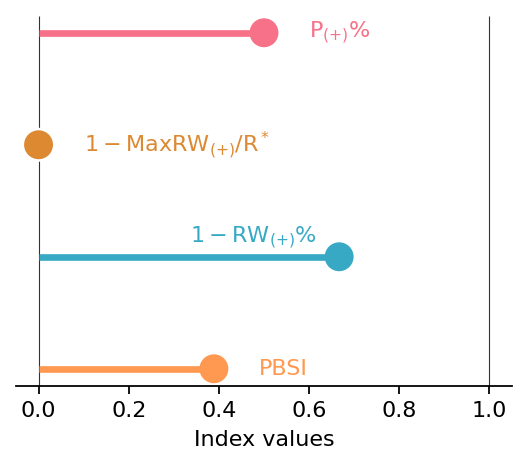

In [20]:
fig, ax = plt.subplots(figsize=(4, 3))

plot_grn_metrics(ax=ax, arr=grn.grn_arr)

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_metrics.pdf", **kwarg_savefig)

---
## Apoptosis

In [23]:
gl = GeneList(
    df, key="apoptosis", category="Apoptosis",
    database=hallmark, preset=True,
)

[Cache Hit] Loading 'apoptosis'...


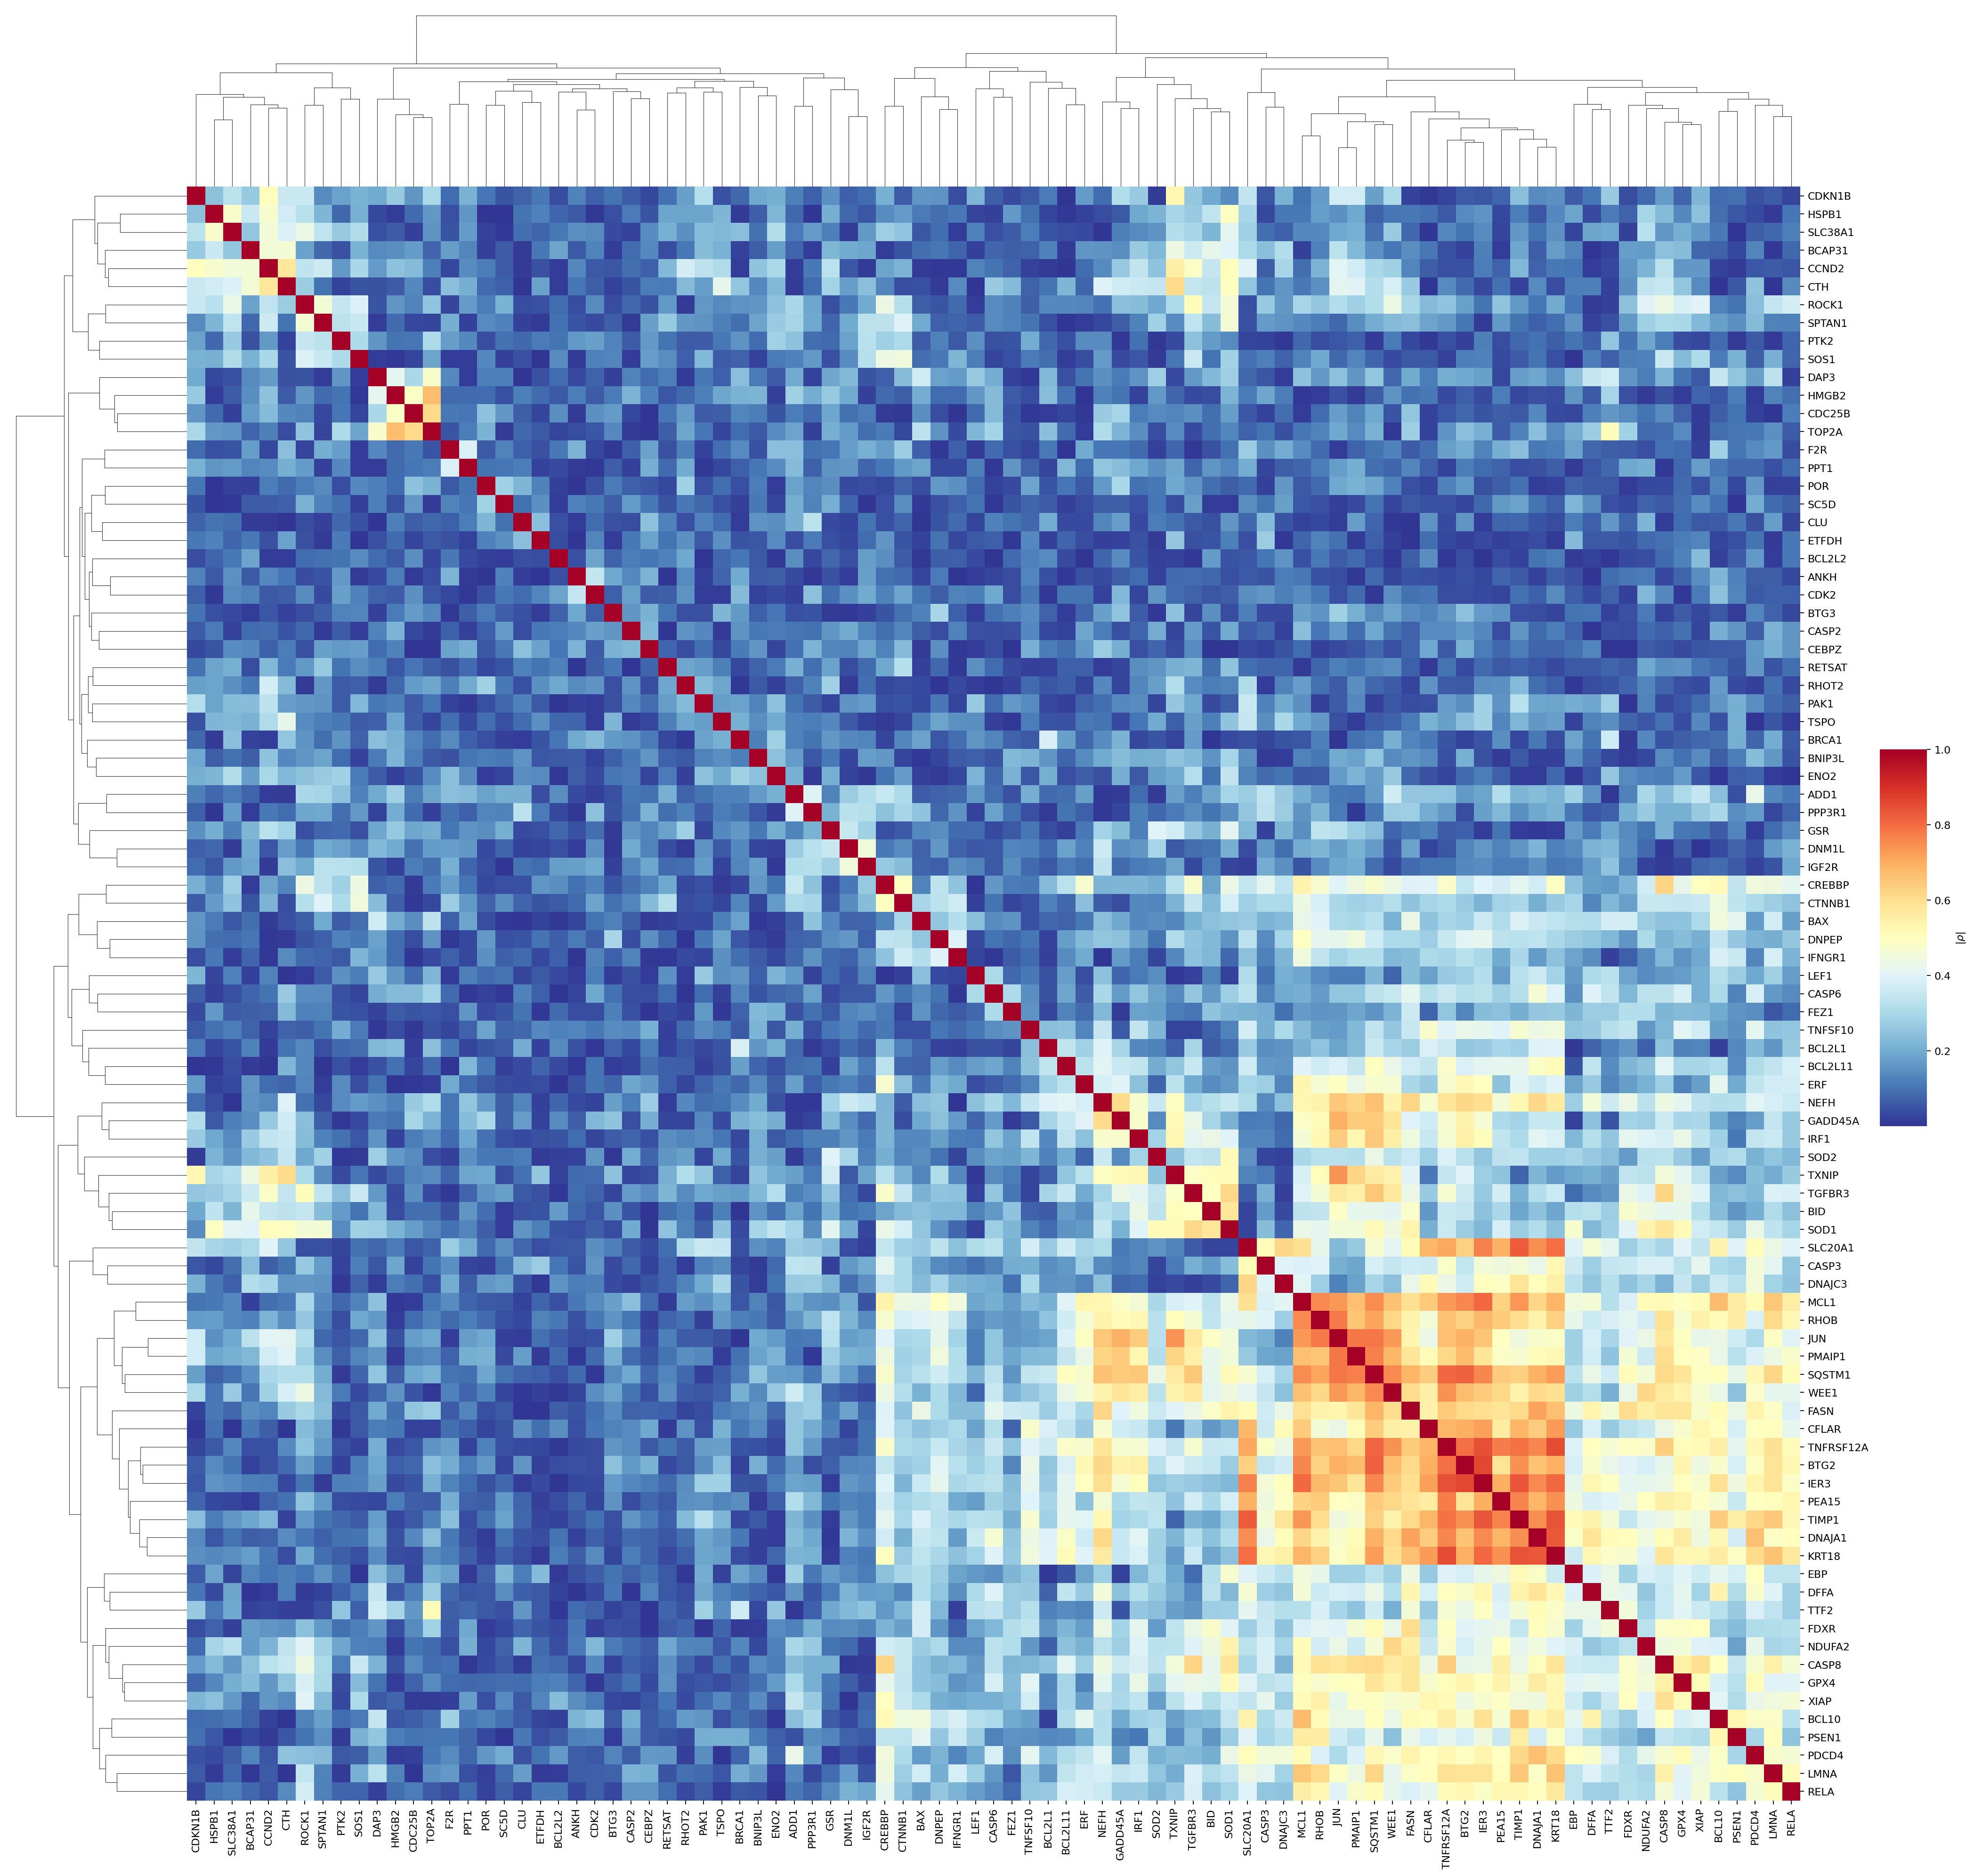

In [25]:
data = gl.data.to_df().assign(
    MetaCell=gl.data.obs["SEACells"]
).groupby("MetaCell", observed=False).mean()
data.columns.name = ""

clustergrid = sns.clustermap(
    data.corr().abs(),
    figsize=(25, 25),
    cbar_pos=(1, .4, .025, .2), 
    dendrogram_ratio=0.1, cmap="RdYlBu_r",
    xticklabels=gl.genes, yticklabels=gl.genes,
    cbar_kws={"label": r"$|\rho|$"},
    rasterized=True
)

plt.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_corr_all.pdf", **kwarg_savefig)

In [26]:
genes, ids = gl.select_independent_genes(n_top=20)

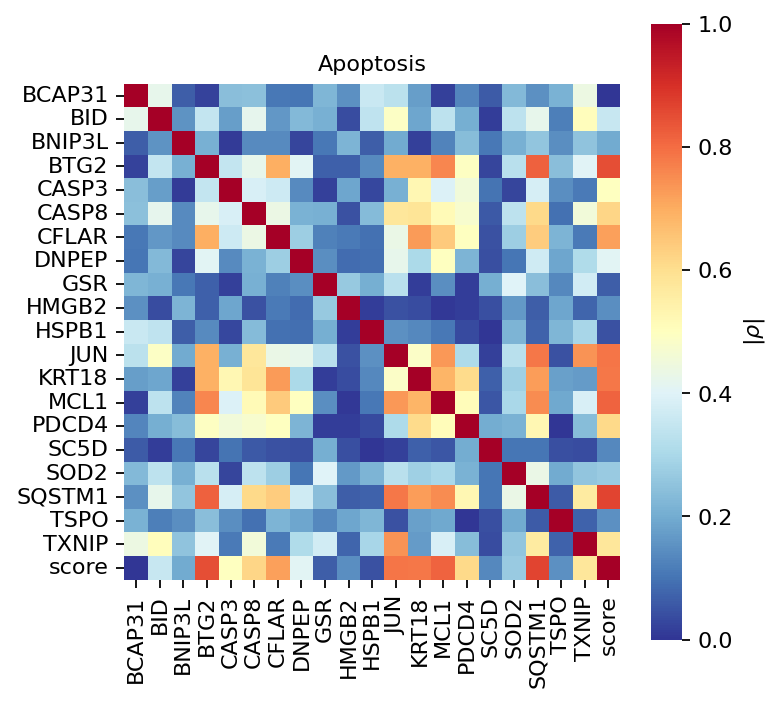

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(
    gl.get_matrix(with_score=True).corr().abs(),
    vmax=1, vmin=0, cmap="RdYlBu_r", square=True, 
    cbar_kws={"label": r"$|\rho|$"}, rasterized=True
)

ax.set(xlabel="", ylabel="");
ax.set_title(gl.category, fontsize="medium")

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_corr.pdf", **kwarg_savefig)

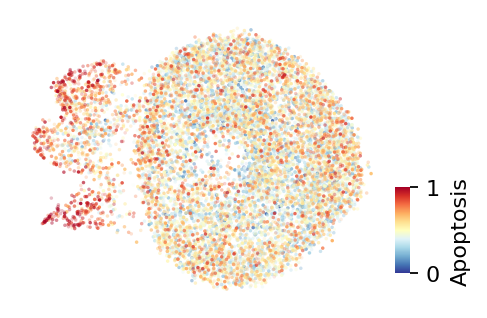

In [28]:
fig, ax = plt.subplots(figsize=(3, 3))

sce.pl.umap(
    gl.data, ax=ax, size=10,
    color=gl.score_prob_name, vmax=1, vmin=0, cmap="RdYlBu_r",
    alpha=gl.data.obs[gl.score_prob_name], title=gl.caption
)

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_score.pdf", **kwarg_savefig)

In [29]:
np.random.seed(0)
random.seed(0)

grn = HillClimbSearch(gene_list=gl, output_value="S_score_prob")

  0%|          | 0/1000000 [00:00<?, ?it/s]

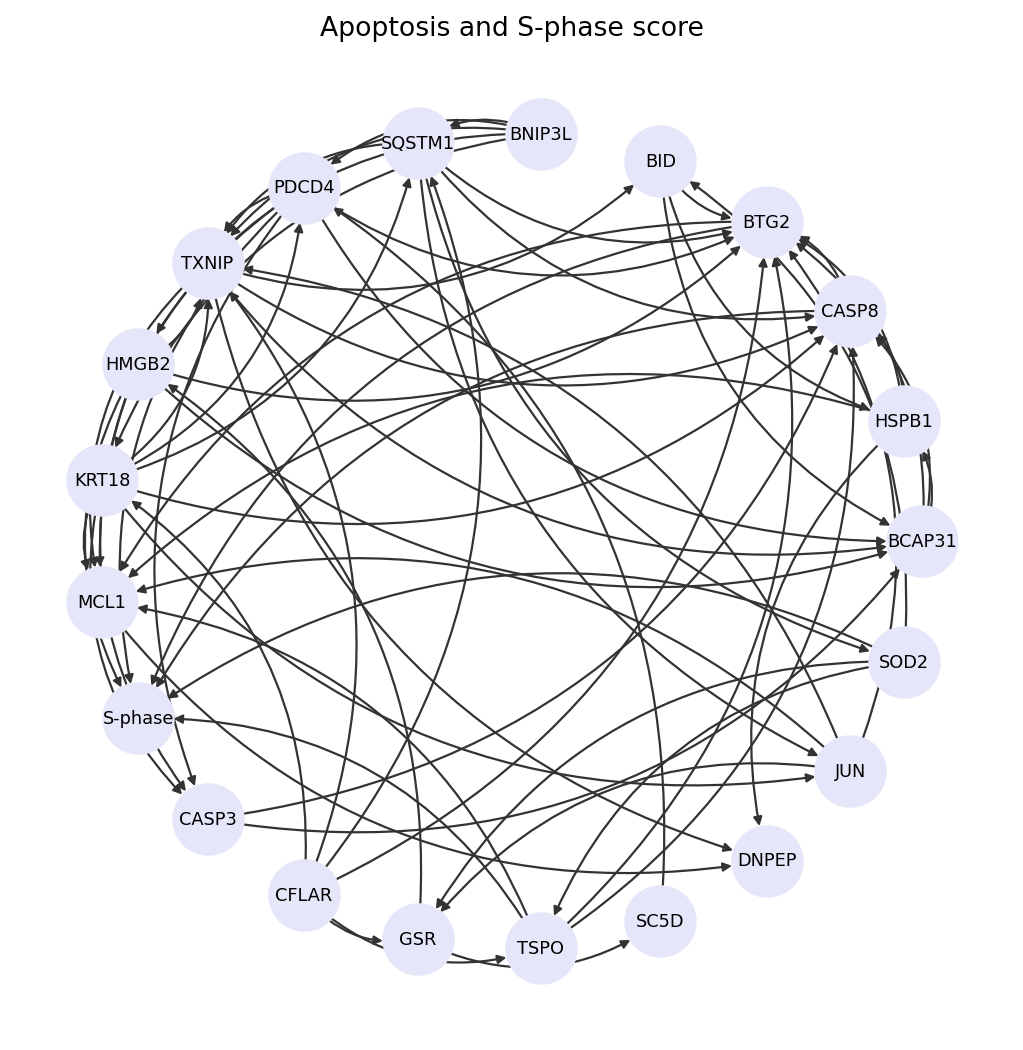

<Figure size 512x384 with 0 Axes>

In [30]:
plt.subplots(figsize=(8, 8))

grn.draw_graph(
    with_labels=True, 
    output_label="S-phase",
    node_color="lavender", edge_color=".2", 
    node_size=1000, font_size=8, width=1,
    arrows=True, arrowsize=8,
    connectionstyle="arc3,rad=0.3"
)

plt.title(f"{gl.caption} and S-phase score")
plt.show()

plt.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_grn_all.pdf", **kwarg_savefig)

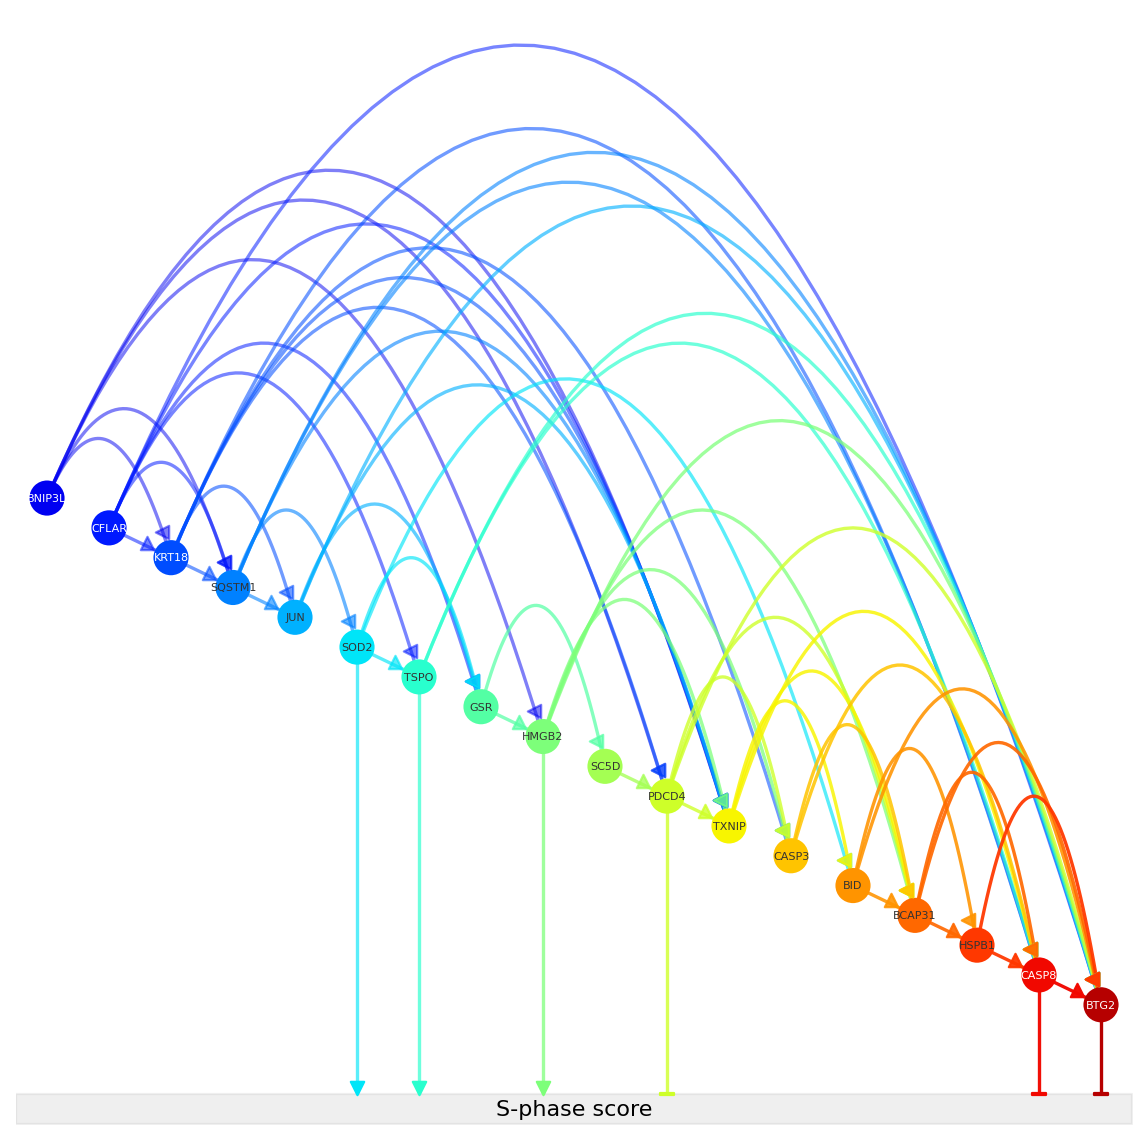

In [31]:
fig, ax = plt.subplots(figsize=(9, 9))

grn.draw_grn(
    ax=ax, 
    output_label="S-phase score",
    markersize=250, fontsize=5
)

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_grn.pdf", **kwarg_savefig)

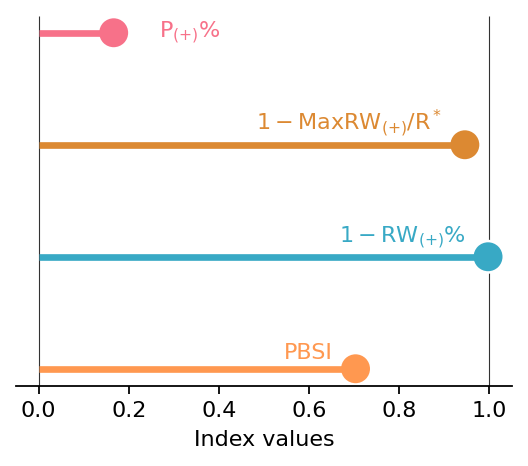

In [32]:
fig, ax = plt.subplots(figsize=(4, 3))

plot_grn_metrics(ax=ax, arr=grn.grn_arr)

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_metrics.pdf", **kwarg_savefig)

---
## G2/M

In [33]:
gl = GeneList(
    adata=df, key="g2m_phase", category="G2-M Checkpoint", 
    database=hallmark, preset=True, caption="G2/M phase"
)

[Cache Hit] Loading 'g2m_phase'...


/home/yokano/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/yokano/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


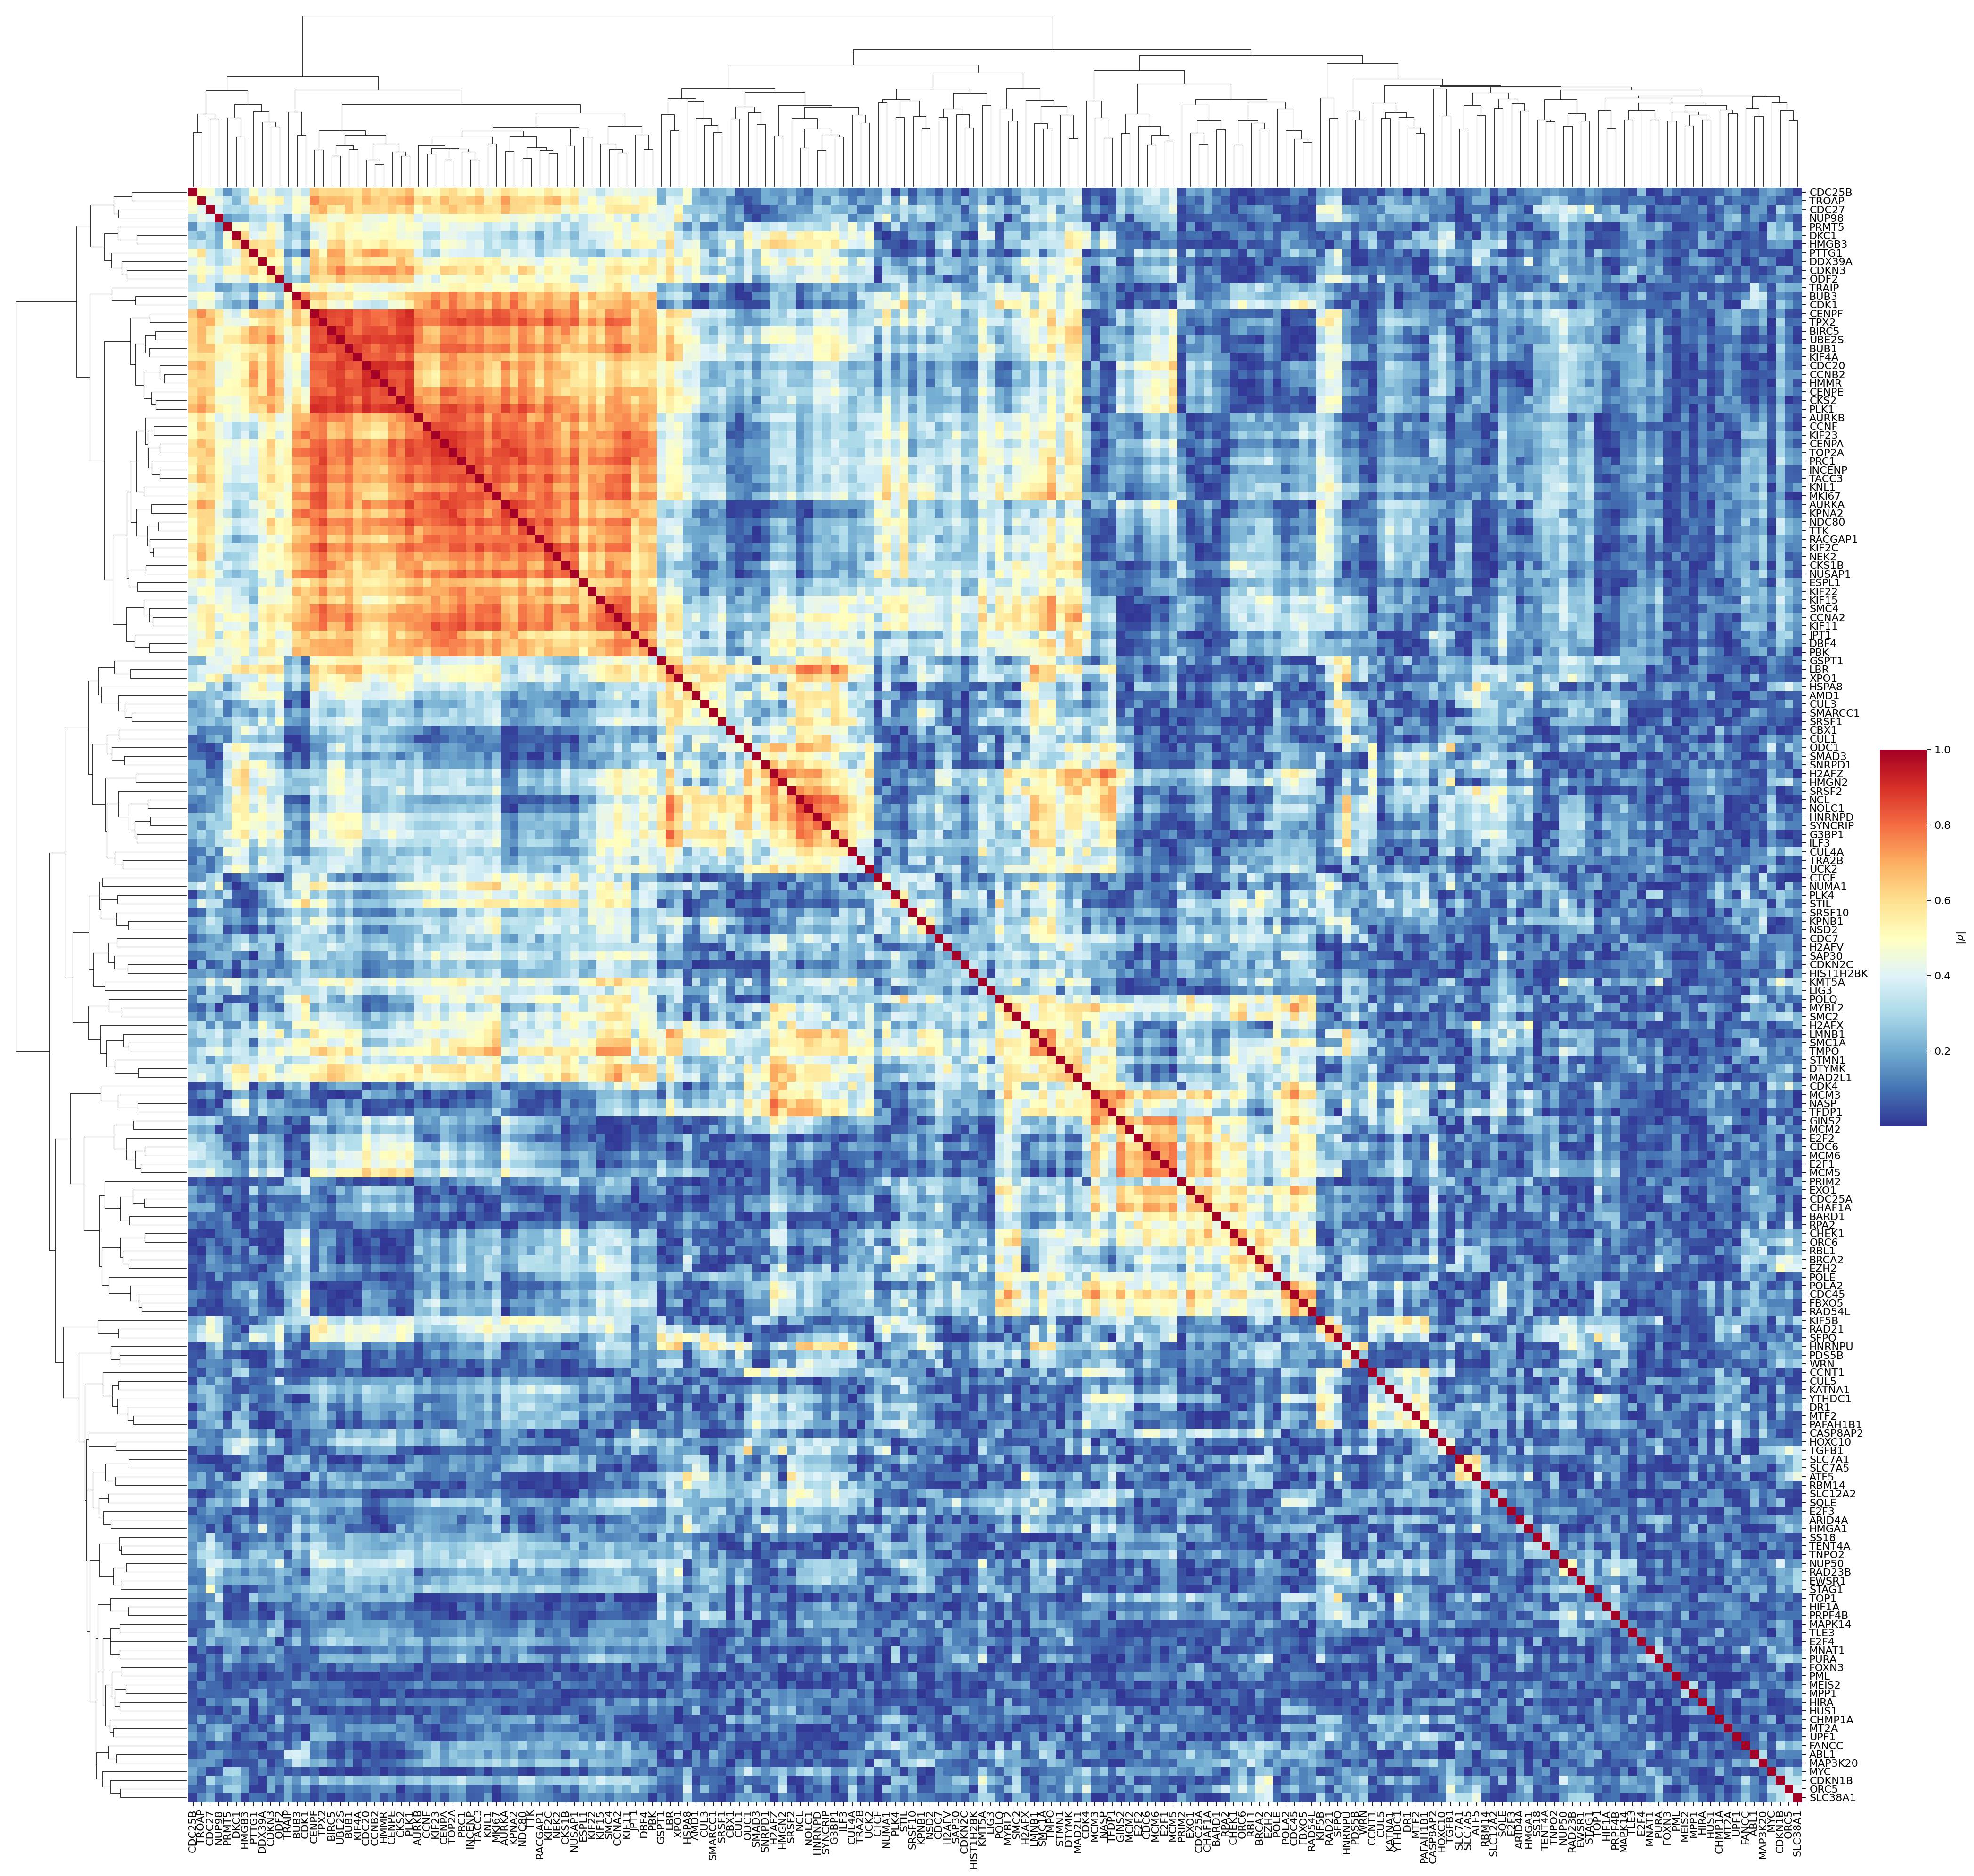

In [34]:
data = gl.data.to_df().assign(
    MetaCell=gl.data.obs["SEACells"]
).groupby("MetaCell", observed=False).mean()
data.columns.name = ""

clustergrid = sns.clustermap(
    data.corr().abs(),
    figsize=(25, 25),
    cbar_pos=(1, .4, .025, .2), 
    dendrogram_ratio=0.1, cmap="RdYlBu_r",
    xticklabels=gl.genes, yticklabels=gl.genes,
    cbar_kws={"label": r"$|\rho|$"},
    rasterized=True
)

plt.savefig(f"{outputdir}/{gl.caption.replace("/", "-").replace(' ', '_')}_corr_all.pdf", **kwarg_savefig)

In [35]:
genes, ids = gl.select_correlated_genes(n_top=20)

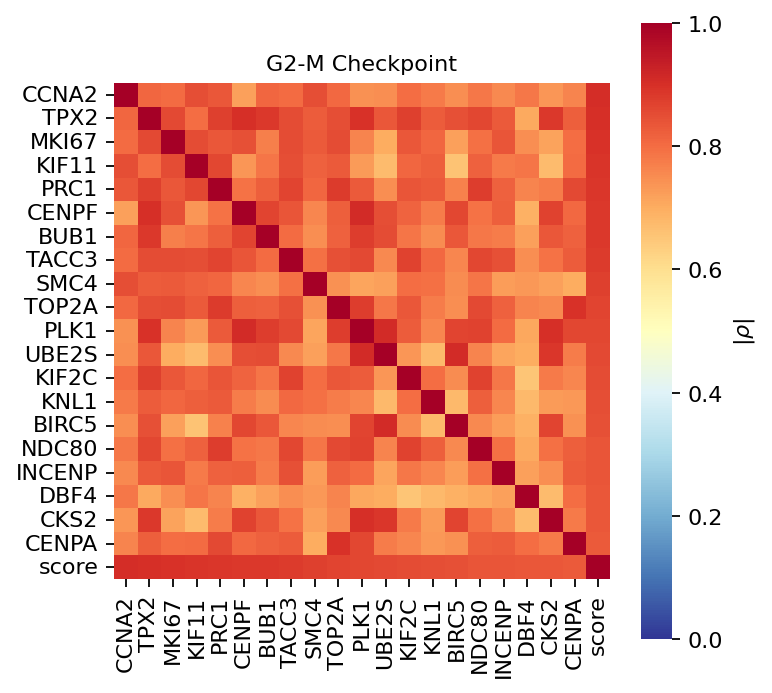

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(
    gl.get_matrix(with_score=True).corr().abs(),
    vmax=1, vmin=0, cmap="RdYlBu_r", square=True, 
    cbar_kws={"label": r"$|\rho|$"}, rasterized=True
)

ax.set(xlabel="", ylabel="");
ax.set_title(gl.category, fontsize="medium")

fig.savefig(f"{outputdir}/{gl.caption.replace("/", "-").replace(' ', '_')}_corr.pdf", **kwarg_savefig)

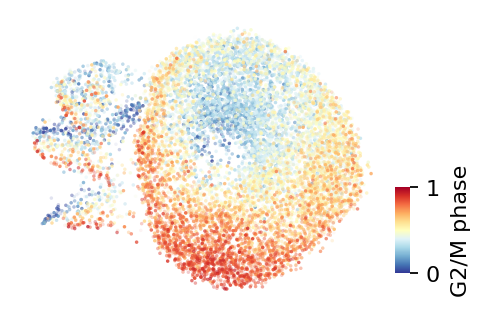

In [37]:
fig, ax = plt.subplots(figsize=(3, 3))

sce.pl.umap(
    gl.data, ax=ax, size=10,
    color=gl.score_prob_name, vmax=1, vmin=0, cmap="RdYlBu_r",
    alpha=gl.data.obs[gl.score_prob_name], title=gl.caption
)

fig.savefig(f"{outputdir}/{gl.caption.replace("/", "-").replace(' ', '_')}_score.pdf", **kwarg_savefig)

In [38]:
np.random.seed(0)
random.seed(0)

grn = HillClimbSearch(gene_list=gl, output_value="S_score_prob")

  0%|          | 0/1000000 [00:00<?, ?it/s]

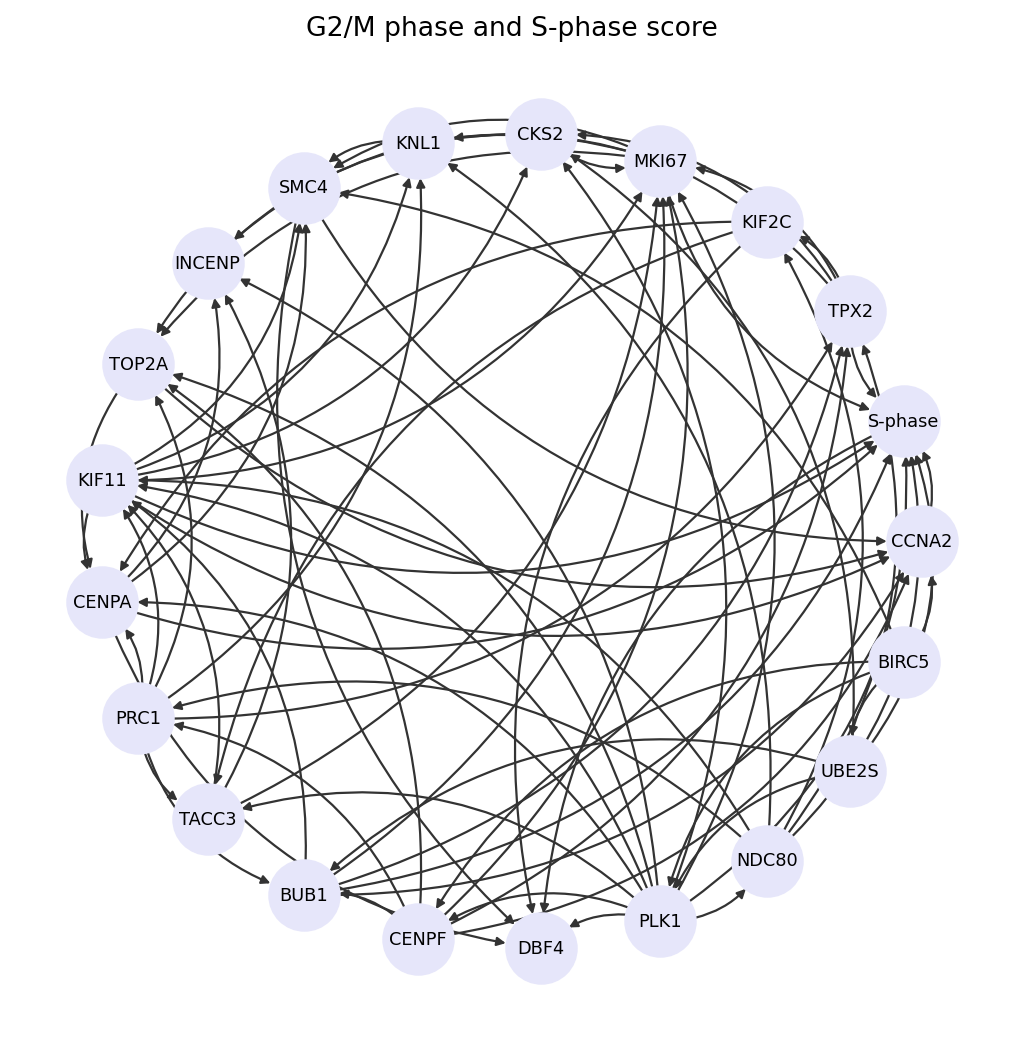

<Figure size 512x384 with 0 Axes>

In [39]:
plt.subplots(figsize=(8, 8))

grn.draw_graph(
    with_labels=True, 
    output_label="S-phase",
    node_color="lavender", edge_color=".2", 
    node_size=1000, font_size=8, width=1,
    arrows=True, arrowsize=8,
    connectionstyle="arc3,rad=0.3"
)

plt.title(f"{gl.caption} and S-phase score")
plt.show()

plt.savefig(f"{outputdir}/{gl.caption.replace("/", "-").replace(' ', '_')}_grn_all.pdf", **kwarg_savefig)

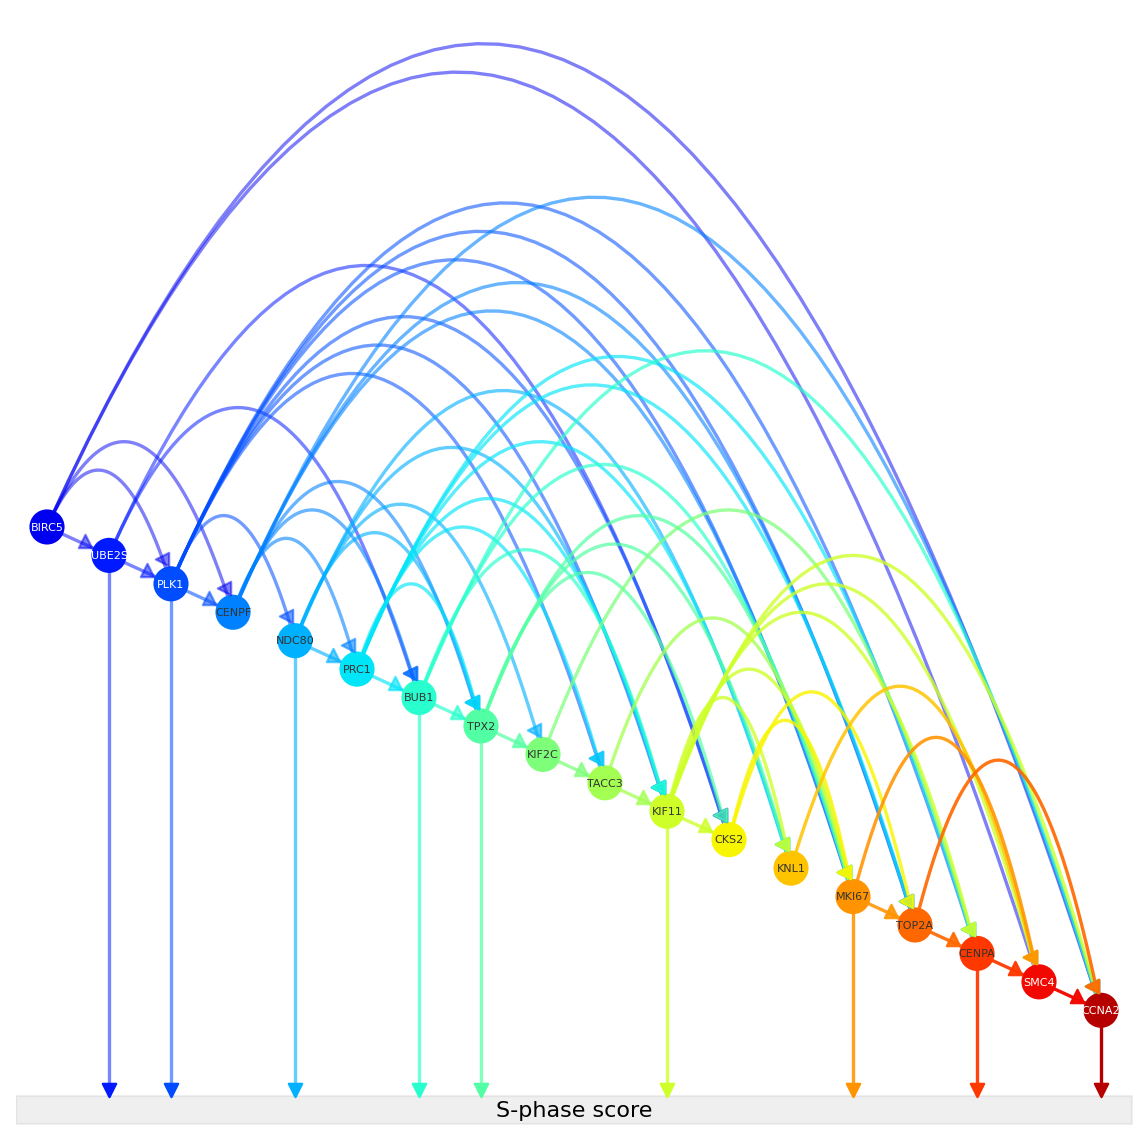

In [40]:
fig, ax = plt.subplots(figsize=(9, 9))

grn.draw_grn(
    ax=ax, 
    output_label="S-phase score",
    markersize=250, fontsize=5
)

fig.savefig(f"{outputdir}/{gl.caption.replace("/", "-").replace(' ', '_')}_grn.pdf", **kwarg_savefig)

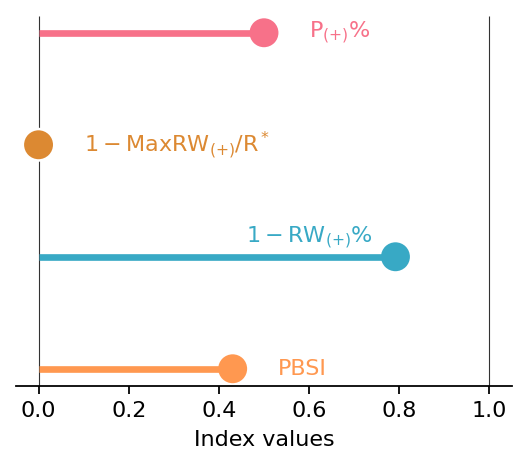

In [41]:
fig, ax = plt.subplots(figsize=(4, 3))

plot_grn_metrics(ax=ax, arr=grn.grn_arr)

fig.savefig(f"{outputdir}/{gl.caption.replace("/", "-").replace(' ', '_')}_metrics.pdf", **kwarg_savefig)

---
## TNF-$\alpha$

In [42]:
gl = GeneList(
    df, key="tnfa", category="TNF-alpha Signaling via NF-kB",
    database=hallmark, preset=True,
    caption="TNF Signaling"
)

[Cache Hit] Loading 'tnfa'...


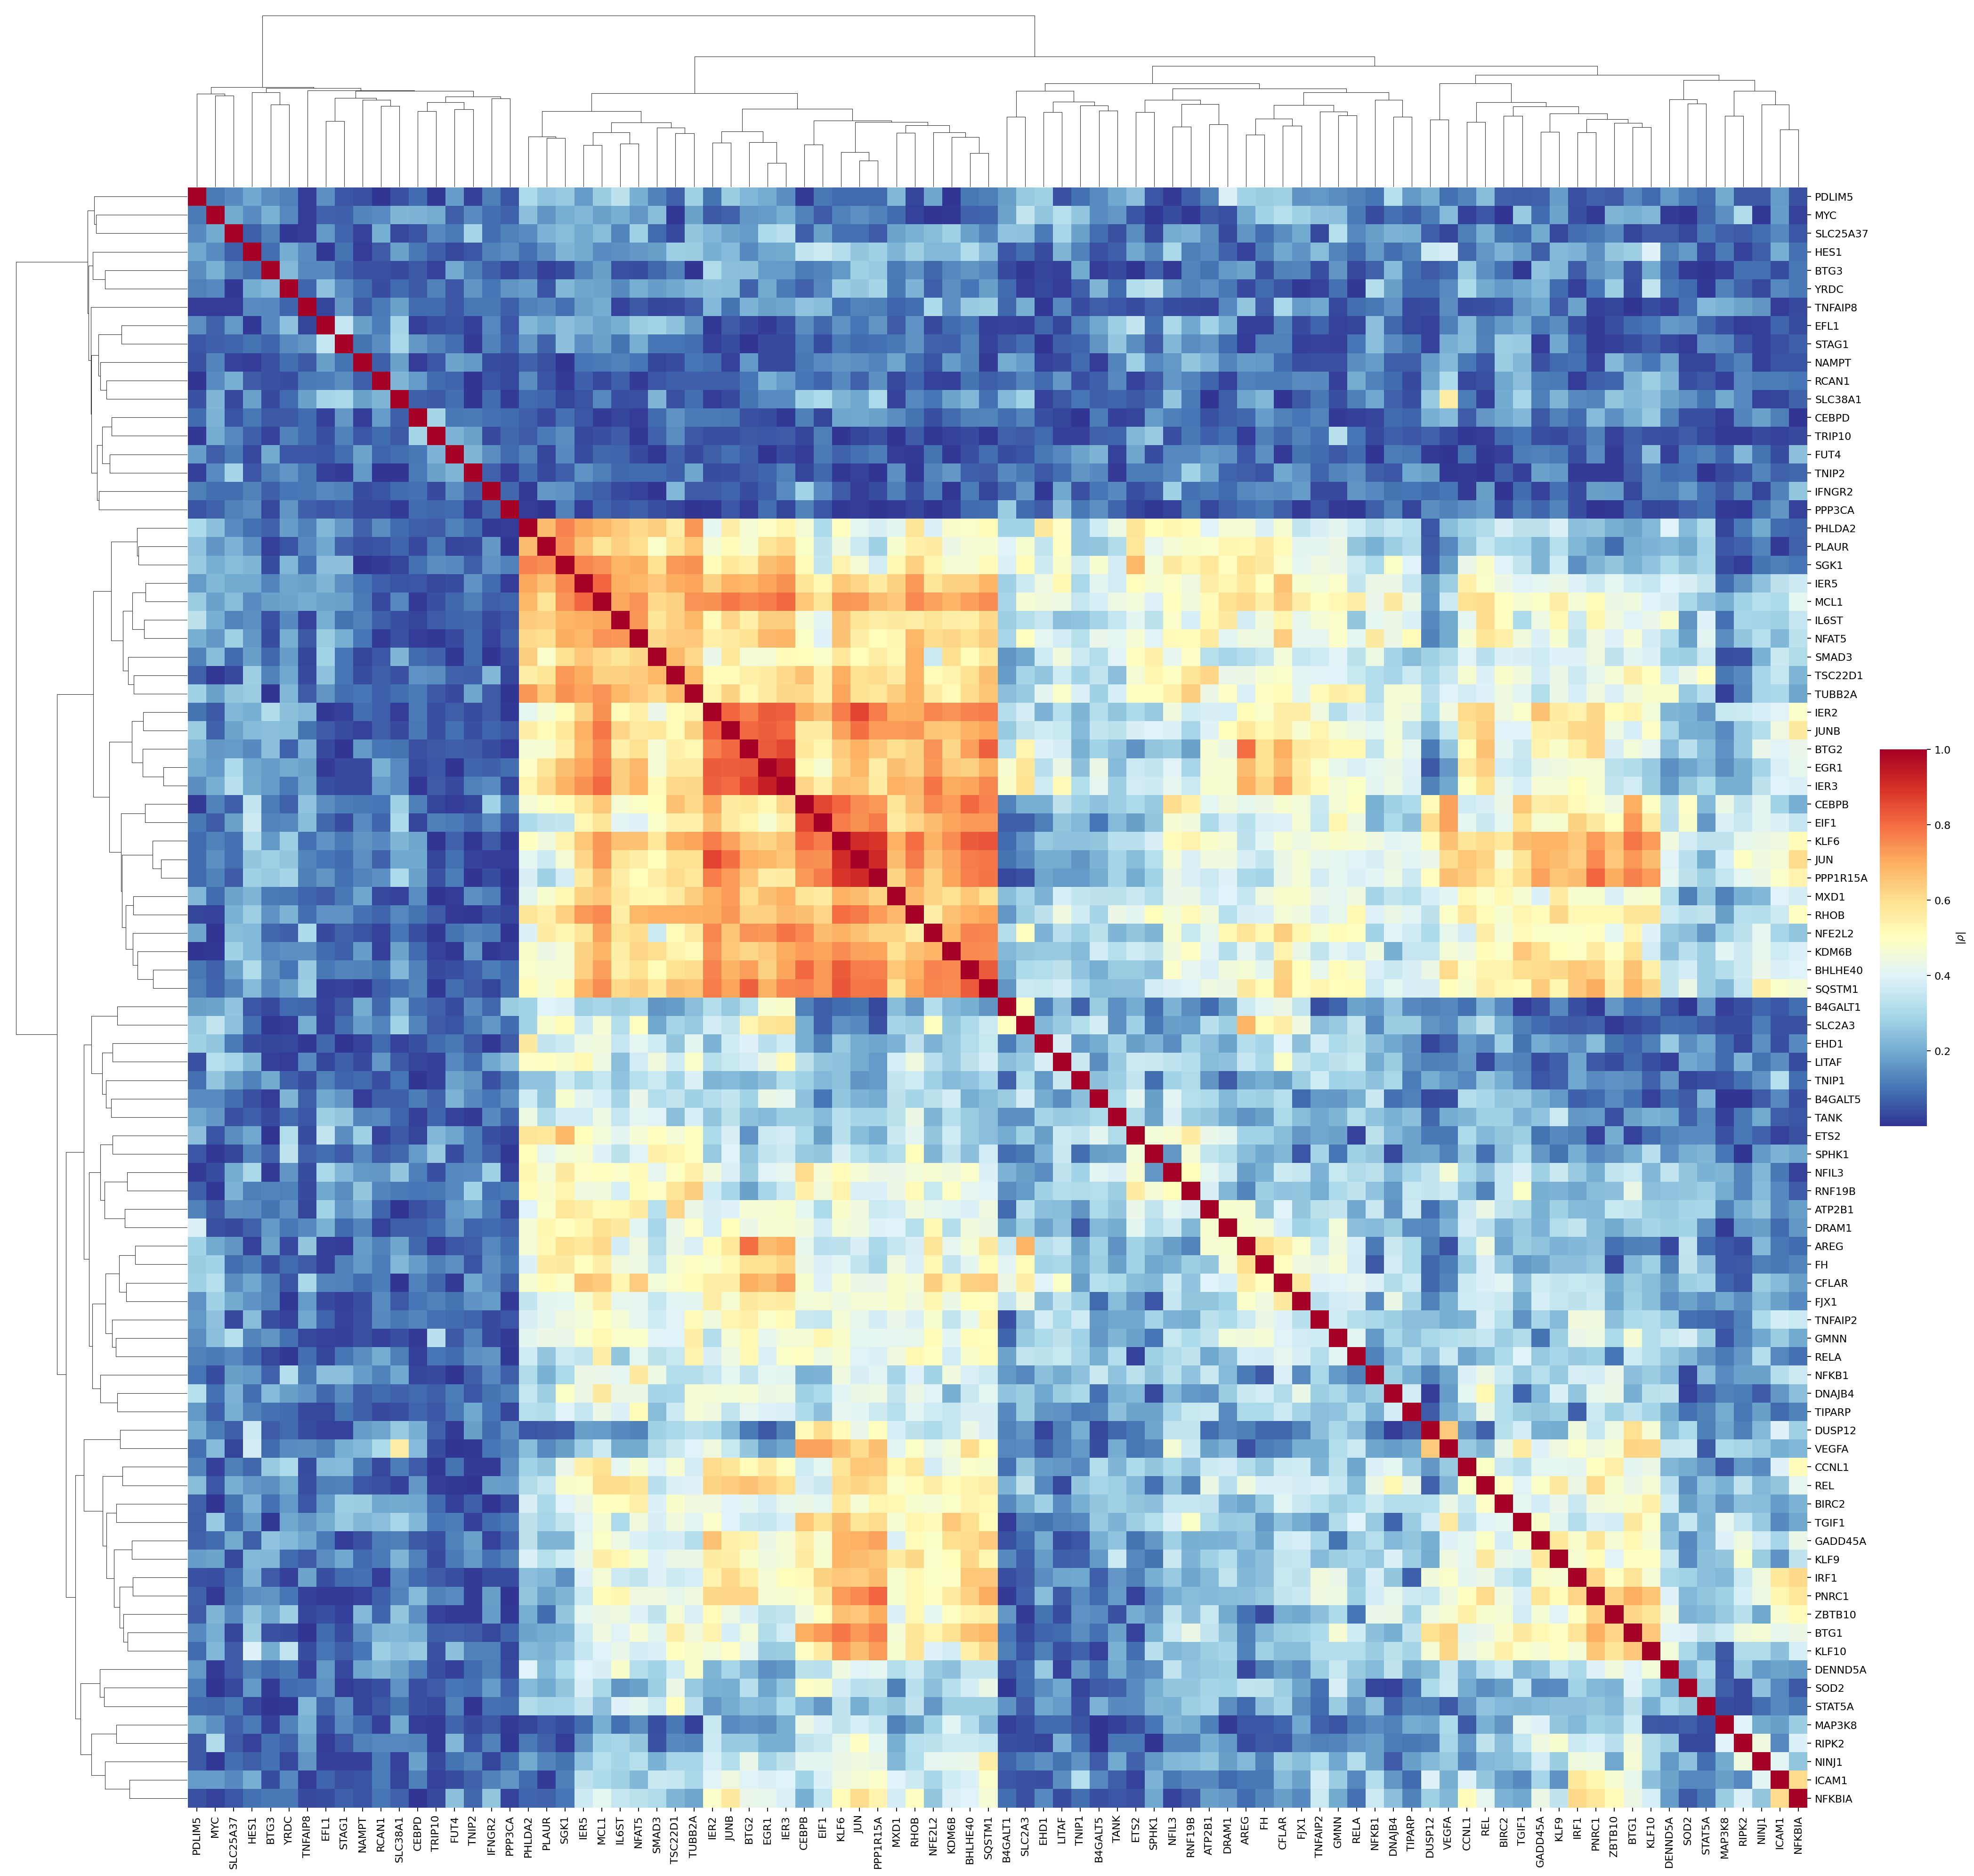

In [43]:
data = gl.data.to_df().assign(
    MetaCell=gl.data.obs["SEACells"]
).groupby("MetaCell", observed=False).mean()
data.columns.name = ""

clustergrid = sns.clustermap(
    data.corr().abs(),
    figsize=(25, 25),
    cbar_pos=(1, .4, .025, .2), 
    dendrogram_ratio=0.1, cmap="RdYlBu_r",
    xticklabels=gl.genes, yticklabels=gl.genes,
    cbar_kws={"label": r"$|\rho|$"},
    rasterized=True
)

plt.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_corr_all.pdf", **kwarg_savefig)

In [44]:
genes, ids = gl.select_independent_genes(n_top=20)

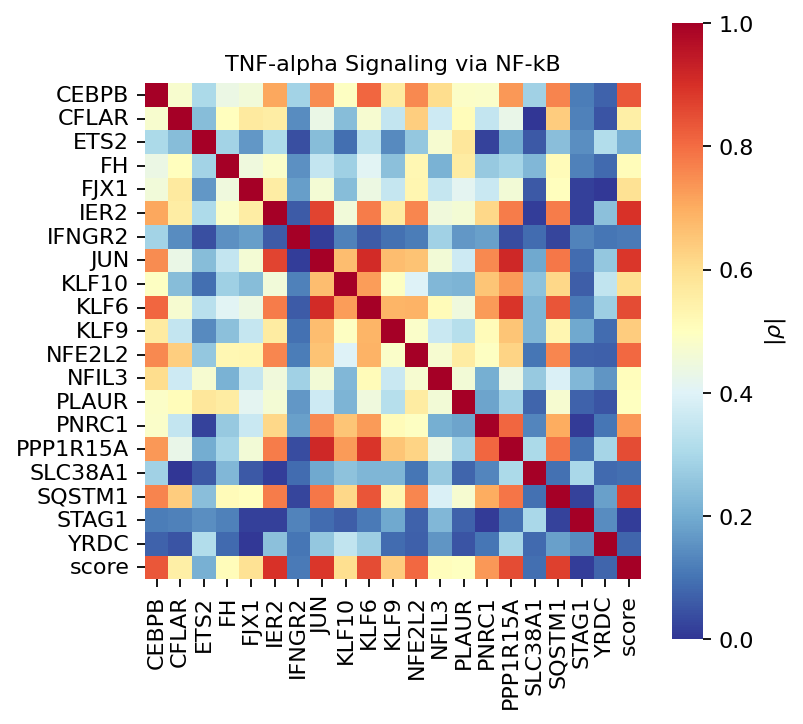

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(
    gl.get_matrix(with_score=True).corr().abs(),
    vmax=1, vmin=0, cmap="RdYlBu_r", square=True, 
    cbar_kws={"label": r"$|\rho|$"}, rasterized=True
)

ax.set(xlabel="", ylabel="");
ax.set_title(gl.category, fontsize="medium")

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_corr.pdf", **kwarg_savefig)

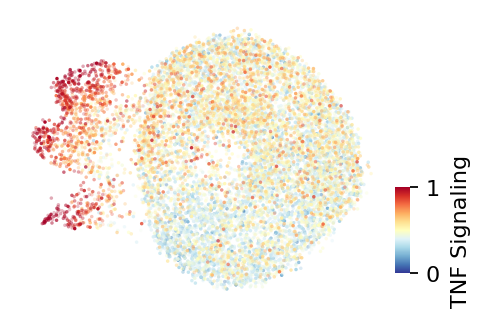

In [46]:
fig, ax = plt.subplots(figsize=(3, 3))

sce.pl.umap(
    gl.data, ax=ax, size=10,
    color=gl.score_prob_name, vmax=1, vmin=0, cmap="RdYlBu_r",
    alpha=gl.data.obs[gl.score_prob_name], title=gl.caption
)

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_score.pdf", **kwarg_savefig)

In [47]:
np.random.seed(0)
random.seed(0)

grn = HillClimbSearch(gene_list=gl, output_value="S_score_prob")

  0%|          | 0/1000000 [00:00<?, ?it/s]

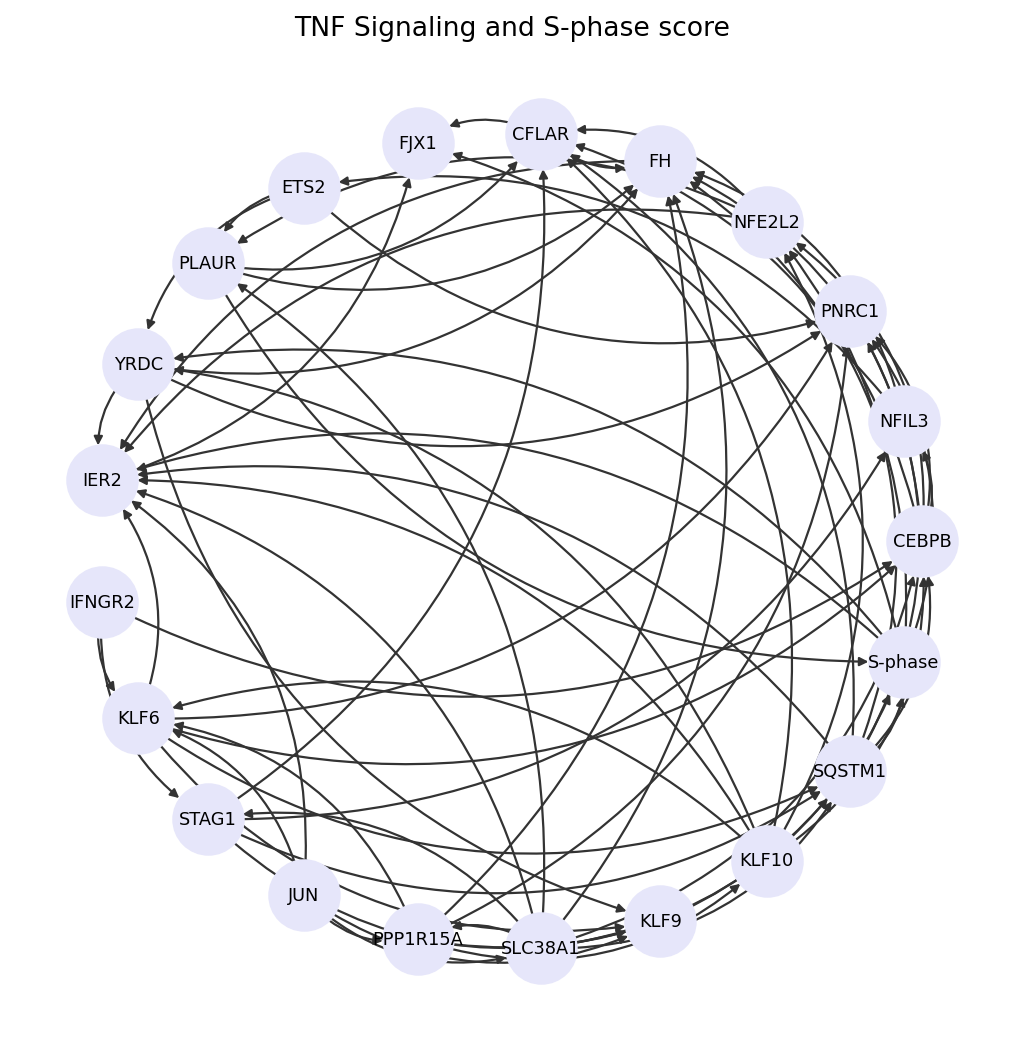

<Figure size 512x384 with 0 Axes>

In [48]:
plt.subplots(figsize=(8, 8))

grn.draw_graph(
    with_labels=True, 
    output_label="S-phase",
    node_color="lavender", edge_color=".2", 
    node_size=1000, font_size=8, width=1,
    arrows=True, arrowsize=8,
    connectionstyle="arc3,rad=0.3"
)

plt.title(f"{gl.caption} and S-phase score")
plt.show()

plt.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_grn_all.pdf", **kwarg_savefig)

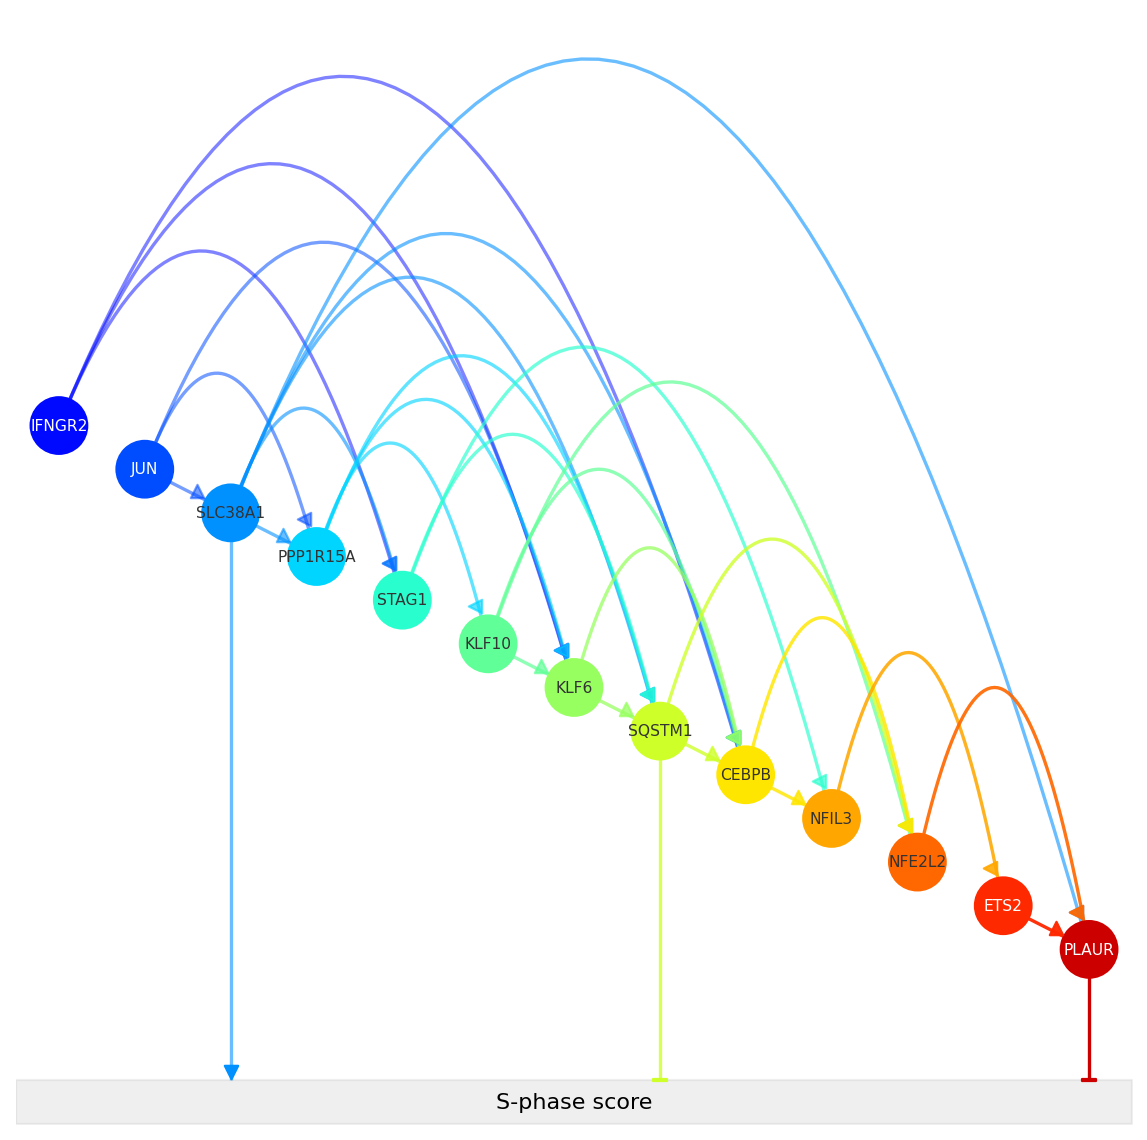

In [49]:
fig, ax = plt.subplots(figsize=(9, 9))

grn.draw_grn(
    ax=ax, 
    output_label="S-phase score",
    markersize=700, fontsize=7
)

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_grn.pdf", **kwarg_savefig)

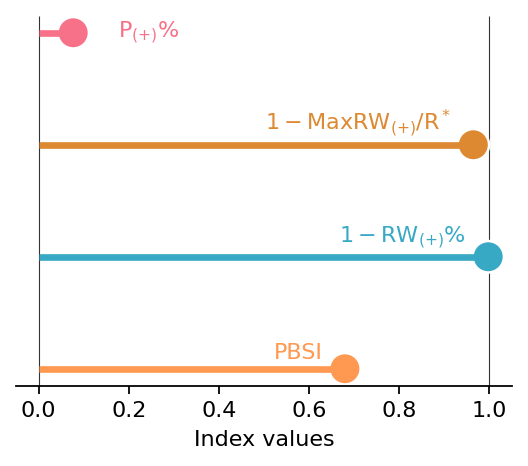

In [50]:
fig, ax = plt.subplots(figsize=(4, 3))

plot_grn_metrics(ax=ax, arr=grn.grn_arr)

fig.savefig(f"{outputdir}/{gl.caption.replace(' ', '_')}_metrics.pdf", **kwarg_savefig)